# DTSC 691 Machine Learning Project
## Diabetes Prediction Classifier
### Liam O'Neill

## Table of Contents

* [Background](#first-bullet)
* [Common Imports](#second-bullet)
* [Import and Display BRFSS 2020 Data](#third-bullet)
* [Initial Feature Selection](#fourth-bullet)
* [Exploratory Data Analysis and Data Cleaning](#eda)
    * [Overview of Remaining Features](#eda1)
    * [DIABETE4](#DIABETE4)
    * [GENHLTH](#GENHLTH)
    * [PHYSHLTH](#PHYSHLTH)
    * [MENTHLTH](#MENTHLTH)
    * [POORHLTH](#POORHLTH)
    * [SLEPTIM1](#SLEPTIM1)
    * [CVDSTRK3](#CVDSTRK3)
    * [ASTHMA3](#ASTHMA3)
    * [HAVARTH4](#HAVARTH4)
    * [DIFFWALK](#DIFFWALK)
    * [SMOKE100](#SMOKE100)
    * [ECIGARET](#ECIGARET)
    * [_IMPRACE](#_IMPRACE)
    * [_TOTINDA](#_TOTINDA)
    * [_MICHD](#_MICHD)
    * [_SEX](#_SEX)
    * [_AGE80](#_AGE80)
    * [_BMI5](#_BMI5)
    * [_EDUCAG](#_EDUCAG)
    * [_INCOMG](#_INCOMG)
    * [Frequency by Diabetes State](#eda2)
        * [Binary Features](#eda2.1)
        * [Categorical Features](#eda2.2)
        * [Numerical Features](#eda2.3)
    * [Correlation Matrix](#eda3)
* [Preprocessing and Splitting the Data](#split)
    * [Preprocessing and Splitting the Data](#split2)
    * [Preprocessing and Splitting the Data](#split3)
* [Train 5 Basic Models](#basic)
    * [Decision Tree Classifier](#dtc)
    * [Random Forest Classifier](#rfc)
    * [XGBoost Classifier](#xgbc)
    * [Hist Gradient Boosting Classifier](#gbc)
    * [Neural Network](#ann)
    * [Compare all models](#all)
* [Optimal Model Selection and Hyperparameter Tuning](#optimal)
    * [XGBoost Classifier Grid Search](#optimal1)
    * [ANN Grid Search](#optimal2)
* [Final Model Selection](#final)
* [Discussion](#deploy)
* [References](#references)

## Background <a class="anchor" id="first-bullet"></a>

Diabetes Mellitus is a group of metabolic diseases which are characterized by sustained high blood sugar resulting from problems with production and use of insulin by the body’s cells.$^{1-3}$ Type-1 diabetes, otherwise known as juvenile diabetes, is an auto-immune disorder where the beta cells that produce insulin in the pancreas are destroyed by the body’s immune system, and insulin production (which is needed for proper management of blood sugar) is compromised.$^{3}$ The exact cause of the damage is unknown, however, it is not believed to be caused by preventable health behaviors.$^{3}$ On the other hand, Type-2 or adult-onset diabetes is a mostly preventable health condition which involves insufficient insulin production from the pancreas due to an increasing insulin resistance (where the cells do not respond as readily to insulin).$^{3}$ Type-2 diabetes is caused by lifestyle factors such as age, Body Mass Index (BMI), ethnicity, family history of diabetes, previously giving birth to a baby above 9lbs, physical inactivity, high blood pressure, high blood HDL (cholesterol), high blood triglycerides, heart disease, other conditions associated with insulin resistance, and certain drug treatments.$^{4-5}$ If left untreated, it can lead to heart disease, stroke, kidney disease, vision problems, dental disease, and nerve damage.$^{6}$

As of the 2022 National Diabetes Statistics Report,$^{7}$ 37.3 million (11.8%) Americans aged 18 or older have Diabetes, and 8.5 million of those adults have not been diagnosed.$^{7}$ In addition to this, 96 million adults in the US have prediabetes, a reversible condition where blood sugar levels are elevated (although lower than diabetes) due to insulin resistance.$^{7,8}$ This report indicates a significant estimated cost of diabetes as well, stating that the “total estimated cost of diagnosed diabetes in 2017 was 327 billion USD, including 237 billion in direct medical costs and 90 billion in lost productivity”.$^{7}$ 

While this condition is manageable with treatment, prevention is the best solution through avoidance of any health complications due to the disease.$^{8}$ Type-2 diabetes involves a number of easily measurable risk factors which contribute to its diagnosis, despite this, many people are unaware of exactly what these factors are, leading to a large proportion of the adult population developing the condition later in life.

Considering the preventable nature of the disease and the relationship between the risk factors and diagnosis, there is an opportunity to predict a person’s disease state (diabetes and prediabetes or no diabetes) using machine learning. For this project, we aim to create and train a machine learning model which can predict an individual’s disease state based on the risk factors included in the training data. This model will be saved and used in a web application, where an individual’s risk behaviors can be entered, and the model will predict whether or not this person is likely to be either diabetic or prediabetic, and should seek medical advice.

The Behavioral Risk Factor Surveillance System (BRFSS) is a yearly survey conducted by the Centers for Disease Control and Prevention (CDC) which aims to collect information on risk factors and health conditions through use of a telephone interview administered by each of the 50 states.$^{9}$ The annual survey data from the BRFSS is available at the CDC’s website, and ranges from 1987 to 2021.$^{10}$ 

For this project we will use one year of current data (2020) which has been converted into CSV format by Kaggle user Ahmet Emre.$^{11}$ Since the analysis will not be concerned with changes in demographic information surrounding diabetes (and as such, not concerned in the change from year to year), one year of survey data will suffice. This also produces the added benefit of having all of the features remain the same (the survey questions vary slightly from year to year).

## Imports <a class="anchor" id="second-bullet"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
import joblib

# Set display to view all columns in scrolling bar
pd.set_option('display.max_columns', None)

# Silence warnings for notebook display for presentation
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Functions for plotting

# Plot Binary Features
def plot_binary_variables(binary, label):
    num_plots = len(binary.columns)
    num_cols = min(num_plots, 4)
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5*num_rows))

    for i, feature in enumerate(binary.columns):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        # Plot the distribution of the feature for each diabetes state
        bins = np.histogram(binary[feature], bins='auto')[1]  # Determine the bins automatically
        width = 0.35  # Width of the bars

        # Diabetes
        hist_1, _ = np.histogram(binary.loc[label['DIABETES'] == 1, feature], bins=bins, density=True)
        ax.bar(bins[:-1] - width/2, hist_1, width=width, color='lightcoral', label='Diabetes')

        # No Diabetes
        hist_0, _ = np.histogram(binary.loc[label['DIABETES'] == 0, feature], bins=bins, density=True)
        ax.bar(bins[:-1] + width/2, hist_0, width=width, color='lightblue', label='No Diabetes')

        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.set_xticks([0, 1])
        ax.legend()

    # Remove empty subplots
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

    plt.tight_layout()
    plt.show()

# Plot Categorical Features
def plot_categorical_variables(categorical, label):
    num_plots = len(categorical.columns)
    num_cols = min(num_plots, 2)
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

    for i, feature in enumerate(categorical.columns):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        # Plot the distribution of the feature for each diabetes state
        for diabetes_label in sorted(label['DIABETES'].unique()):
            subset = categorical[label['DIABETES'] == diabetes_label][feature]
            subset_counts = subset.value_counts()
            ax.bar(subset_counts.index, subset_counts.values,
                   color='lightcoral' if diabetes_label == 1 else 'lightblue',
                   label=f'Diabetes: {diabetes_label}')

        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.legend()

    # Remove empty subplots
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

    plt.tight_layout()
    plt.show()

# Plot Numerical Variables
def plot_numerical_variables(numerical, label, features):
    num_plots = len(features)
    num_cols = min(num_plots, 2)
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        for diabetes_label in sorted(label['DIABETES'].unique()):
            subset = numerical[label['DIABETES'] == diabetes_label][feature]

            sns.histplot(subset, ax=ax, bins=15,
                         color='lightcoral' if diabetes_label == 1 else 'lightblue',
                         kde=True, alpha=0.5, label=f'Diabetes: {diabetes_label}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()

    # Remove empty subplots
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

    plt.tight_layout()
    plt.show()

## Import and Display BRFSS 2020 Data <a class="anchor" id="third-bullet"></a>
The first step is to import the data using pandas read_csv function. The data used here is taken from Kaggle user Ahmet Emre$^{11}$, and is a csv file of the 2020 BRFSS data. Here we are going to import the data and then display the data so that we can confirm the data was imported correctly, and can get a sense of what the data looks like.

In [3]:
# Import data from csv file
data = pd.read_csv('brfss2020.csv')
# create copy
data_copy = data.copy()
data

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,PVTRESD1,COLGHOUS,STATERE1,CELPHONE,LADULT1,COLGSEX,NUMADULT,LANDSEX,NUMMEN,NUMWOMEN,RESPSLCT,SAFETIME,CTELNUM1,CELLFON5,CADULT1,CELLSEX,PVTRESD3,CCLGHOUS,CSTATE1,LANDLINE,HHADULT,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,CVDINFR4,CVDCRHD4,CVDSTRK3,ASTHMA3,ASTHNOW,CHCSCNCR,CHCOCNCR,CHCCOPD2,HAVARTH4,ADDEPEV3,CHCKDNY2,DIABETE4,DIABAGE3,LASTDEN4,RMVTETH4,MARITAL,EDUCA,RENTHOM1,NUMHHOL3,NUMPHON3,CPDEMO1B,VETERAN3,EMPLOY1,CHILDREN,INCOME2,PREGNANT,WEIGHT2,HEIGHT3,DEAF,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,SMOKE100,SMOKDAY2,STOPSMK2,LASTSMK2,USENOW3,ALCDAY5,AVEDRNK3,DRNK3GE5,MAXDRNKS,FLUSHOT7,FLSHTMY3,SHINGLE2,PNEUVAC4,FALL12MN,FALLINJ4,SEATBELT,DRNKDRI2,HADMAM,HOWLONG,HADPAP2,LASTPAP2,HPVTEST,HPLSTTST,HADHYST2,PCPSAAD3,PCPSADI1,PCPSARE1,PSATEST1,PSATIME,PCPSARS1,COLNSCPY,COLNTEST,SIGMSCPY,SIGMTEST,BLDSTOL1,LSTBLDS4,STOOLDNA,SDNATEST,VIRCOLON,VCLNTEST,HIVTST7,HIVTSTD3,HIVRISK5,PDIABTST,PREDIAB1,INSULIN1,BLDSUGAR,FEETCHK3,DOCTDIAB,CHKHEMO3,FEETCHK,EYEEXAM1,DIABEYE,DIABEDU,TOLDCFS,HAVECFS,WORKCFS,TOLDHEPC,TRETHEPC,PRIRHEPC,HAVEHEPC,HAVEHEPB,MEDSHEPB,HLTHCVR1,CIMEMLOS,CDHOUSE,CDASSIST,CDHELP,CDSOCIAL,CDDISCUS,CAREGIV1,CRGVREL4,CRGVLNG1,CRGVHRS1,CRGVPRB3,CRGVALZD,CRGVPER1,CRGVHOU1,CRGVEXPT,ECIGARET,ECIGNOW,MARIJAN1,USEMRJN2,RSNMRJN1,LCSFIRST,LCSLAST,LCSNUMCG,LCSCTSCN,CNCRDIFF,CNCRAGE,CNCRTYP1,CSRVTRT3,CSRVDOC1,CSRVSUM,CSRVRTRN,CSRVINST,CSRVINSR,CSRVDEIN,CSRVCLIN,CSRVPAIN,CSRVCTL2,PCPSADE1,PCDMDEC1,HPVADVC4,HPVADSHT,TETANUS1,IMFVPLA1,BIRTHSEX,SOMALE,SOFEMALE,TRNSGNDR,ACEDEPRS,ACEDRINK,ACEDRUGS,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT1,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,RCSGENDR,RCSRLTN2,CASTHDX2,CASTHNO2,QSTVER,QSTLANG,_METSTAT,_URBSTAT,MSCODE,_STSTR,_STRWT,_RAWRAKE,_WT2RAKE,_IMPRACE,_CHISPNC,_CRACE1,_CPRACE,_CLLCPWT,_DUALUSE,_DUALCOR,_LLCPWT2,_LLCPWT,_RFHLTH,_PHYS14D,_MENT14D,_HCVU651,_TOTINDA,_MICHD,_LTASTH1,_CASTHM1,_ASTHMS1,_DRDXAR2,_EXTETH3,_ALTETH3,_DENVST3,_PRACE1,_MRACE1,_HISPANC,_RACE,_RACEG21,_RACEGR3,_RACEPRV,_SEX,_AGEG5YR,_AGE65YR,_AGE80,_AGE_G,HTIN4,HTM4,WTKG3,_BMI5,_BMI5CAT,_RFBMI5,_CHLDCNT,_EDUCAG,_INCOMG,_SMOKER3,_RFSMOK3,DRNKANY5,DROCDY3_,_RFBING5,_DRNKWK1,_RFDRHV7,_FLSHOT7,_PNEUMO3,_RFSEAT2,_RFSEAT3,_DRNKDRV,_RFMAM22,_MAM5023,_RFPAP35,_RFPSA23,_CLNSCPY,_SGMSCPY,_SGMS10Y,_RFBLDS4,_STOLDNA,_VIRCOLN,_SBONTIM,_CRCREC1,_AIDTST4
0,1.0,1.0,1042020,1,4,2020,1100.0,2020000001,2.020000e+09,1.0,1.0,NaN,1.0,2.0,1.0,NaN,1.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,3.0,30.0,3.0,2.0,3.0,1.0,4.0,1.0,5.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,35.0,1.0,2.0,2.0,6.0,1.0,2.0,NaN,1.0,2.0,4.0,88.0,1.0,NaN,106.0,507.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,NaN,3.0,888.0,NaN,NaN,NaN,2.0,NaN,2.0,2.0,88.0,NaN,1.0,NaN,1.0,3.0,1.0,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,21994.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,7.0,2.0,1.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN,10.0,1.0,1.0,1.0,1.0,11011.0,69.640207,1.0,69.640207,1.0,NaN,NaN,NaN,NaN,1.0,0.465411,460.002849,284.335672,1.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,NaN,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,8.0,1.0,56.0,5.0,67.0,170.0,4808.0,1660.0,1.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,1.0,NaN,NaN,1.0,1.0,9.0,2.0,2.0,NaN,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0
1,1.0,1.0,2072020,2,7,2020,1200.0,2020000002,2.020000e+09,1.0,1.0,NaN,1.0,2.0,1.0,NaN,1.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,88.0,88.0,NaN,1.0,1.0,1.0,1.0,1.0,7.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,NaN,1.0,1.0,3.0,6.0,1.0,1.0,1.0,1.0,2.0,7.0,88.0,99.0,NaN,170.0,504.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Initial Feature Selection <a class="anchor" id="fourth-bullet"></a>
Not all of the features included in the dataset are relevant to our analysis. Now that the data has been imported and is in a data frame format, the features which are not relevant diabetes risk factors based on current diabetes research will be eliminated, leaving only risk factors which are present in diabetes literature. This was accomplished through examining exisiting research, as well as the BRFSS 2020 Codebook located at https://www.cdc.gov/brfss/annual_data/annual_2020.html which outlines for us exactly what question was asked, and how each variable is encoded. We will drop all unqualified features by their corresponding index, and then display the remaining data.$^{12}$

In [4]:
# Drop pre-selected unqualified features
# col 1-32,38-41,43-44,47-50,55-73,75-76,78-120,122-155,157-211,213-224,227-240,242-243,245-248,250-252,255-260,262-279
data.drop(data.iloc[:, np.r_[0:32,37:41,42:44,46:50,54:73,74:76,77:120,121:155,156:211,
               212:224,226:240,241:243,244:248,249:252,254:260,261:279]], inplace=True, axis=1)
data

,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,SLEPTIM1,CVDSTRK3,ASTHMA3,HAVARTH4,ADDEPEV3,CHCKDNY2,DIABETE4,DIFFWALK,SMOKE100,PREDIAB1,ECIGARET,_IMPRACE,_TOTINDA,_MICHD,_SEX,_AGE80,_BMI5,_EDUCAG,_INCOMG,_RFDRHV7
0,2.0,3.0,30.0,3.0,2.0,5.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,NaN,1.0,1.0,1.0,2.0,2.0,56.0,1660.0,4.0,1.0,1.0
1,3.0,88.0,88.0,NaN,1.0,7.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,NaN,1.0,NaN,2.0,1.0,2.0,2.0,65.0,2918.0,4.0,9.0,9.0
2,3.0,88.0,88.0,NaN,1.0,7.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0,65.0,NaN,3.0,5.0,1.0
3,1.0,88.0,88.0,NaN,1.0,6.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,80.0,NaN,2.0,9.0,1.0
4,2.0,88.0,88.0,NaN,1.0,7.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,1.0,2.0,2.0,80.0,2034.0,4.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401953,3.0,88.0,88.0,NaN,2.0,6.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,2.0,3.0,NaN,5.0,1.0,2.0,2.0,45.0,2424.0,3.0,9.0,1.0
401954,3.0,88.0,88.0,NaN,1.0,12.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,NaN,5.0,2.0,2.0,2.0,29.0,3281.0,1.0,2.0,1.0
401955,3.0,88.0,88.0,NaN,1.0,8.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,NaN,5.0,1.0,2.0,2.0,80.0,4656.0,2.0,1.0,1.0
401956,3.0,88.0,88.0,NaN,1.0,6.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,7.0,3.0,NaN,5.0,1.0,2.0,1.0,58.0,2661.0,4.0,9.0,1.0


## Exploratoring Distributions and Data Cleaning <a class="anchor" id="eda"></a>
Now that only the relevant features are remaining, we will begin further analysis and cleaning of the data. This will include examining the distribution of the data, combining similar features together, changing coded values to ensure proper use in training machine learning models, re-naming the columns to better identify which risk factor they represent, and to remove any null values present in the data. Each feature's distribution will be visualized both before and after any changes are made, in order to get a sense of how each feature is distributed in it's current state, and how the data is distributed after our changes are made.
### Overview of Remaining Features <a class="anchor" id="eda1"></a>
In this section we will display summary statistics about the unaltered remaining features, examine the distribution of all remaining features, and search for any missing values.

In [5]:
data.describe()

,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,SLEPTIM1,CVDSTRK3,ASTHMA3,HAVARTH4,ADDEPEV3,CHCKDNY2,DIABETE4,DIFFWALK,SMOKE100,PREDIAB1,ECIGARET,_IMPRACE,_TOTINDA,_MICHD,_SEX,_AGE80,_BMI5,_EDUCAG,_INCOMG,_RFDRHV7
count,401950.000000,401953.000000,401953.000000,201615.000000,401955.000000,401955.000000,401955.000000,401955.000000,401953.000000,401952.000000,401952.000000,401952.000000,386678.000000,384098.000000,218993.000000,264561.000000,401958.000000,401958.000000,398387.000000,401958.000000,401958.000000,360601.000000,401958.000000,401958.000000,401958.000000
mean,2.452947,66.143629,61.453740,55.680525,1.119809,7.944698,1.977167,1.883748,1.720656,1.840546,1.983040,2.763459,1.873326,1.631826,2.750997,1.824071,1.715883,1.250894,1.914247,1.542412,54.429221,2830.631271,3.017589,4.902537,1.670433
std,1.085778,34.827121,36.951143,38.151288,0.562472,7.973949,0.359852,0.473024,0.629013,0.575074,0.387724,0.735095,0.507526,0.703787,0.748552,0.514654,1.464755,0.531942,0.280000,0.498199,17.666723,638.164868,1.040573,2.397897,2.120560
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1202.000000,1.000000,1.000000,1.000000
25%,2.000000,30.000000,15.000000,10.000000,1.000000,6.000000,2.000000,2.000000,1.000000,2.000000,2.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,1.000000,2.000000,1.000000,40.000000,2399.000000,2.000000,3.000000,1.000000
50%,2.000000,88.000000,88.000000,88.000000,1.000000,7.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,57.000000,2732.000000,3.000000,5.000000,1.000000
75%,3.000000,88.000000,88.000000,88.000000,1.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,69.000000,3138.000000,4.000000,5.000000,1.000000
max,9.000000,99.000000,99.000000,99.000000,9.000000,99.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,6.000000,9.000000,2.000000,2.000000,80.000000,9843.000000,9.000000,9.000000,9.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401958 entries, 0 to 401957
Data columns (total 25 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   GENHLTH   401950 non-null  float64
 1   PHYSHLTH  401953 non-null  float64
 2   MENTHLTH  401953 non-null  float64
 3   POORHLTH  201615 non-null  float64
 4   HLTHPLN1  401955 non-null  float64
 5   SLEPTIM1  401955 non-null  float64
 6   CVDSTRK3  401955 non-null  float64
 7   ASTHMA3   401955 non-null  float64
 8   HAVARTH4  401953 non-null  float64
 9   ADDEPEV3  401952 non-null  float64
 10  CHCKDNY2  401952 non-null  float64
 11  DIABETE4  401952 non-null  float64
 12  DIFFWALK  386678 non-null  float64
 13  SMOKE100  384098 non-null  float64
 14  PREDIAB1  218993 non-null  float64
 15  ECIGARET  264561 non-null  float64
 16  _IMPRACE  401958 non-null  float64
 17  _TOTINDA  401958 non-null  float64
 18  _MICHD    398387 non-null  float64
 19  _SEX      401958 non-null  float64
 20  _AGE

In [7]:
data.isnull().sum()

GENHLTH          8
PHYSHLTH         5
MENTHLTH         5
POORHLTH    200343
HLTHPLN1         3
SLEPTIM1         3
CVDSTRK3         3
ASTHMA3          3
HAVARTH4         5
ADDEPEV3         6
CHCKDNY2         6
DIABETE4         6
DIFFWALK     15280
SMOKE100     17860
PREDIAB1    182965
ECIGARET    137397
_IMPRACE         0
_TOTINDA         0
_MICHD        3571
_SEX             0
_AGE80           0
_BMI5        41357
_EDUCAG          0
_INCOMG          0
_RFDRHV7         0
dtype: int64

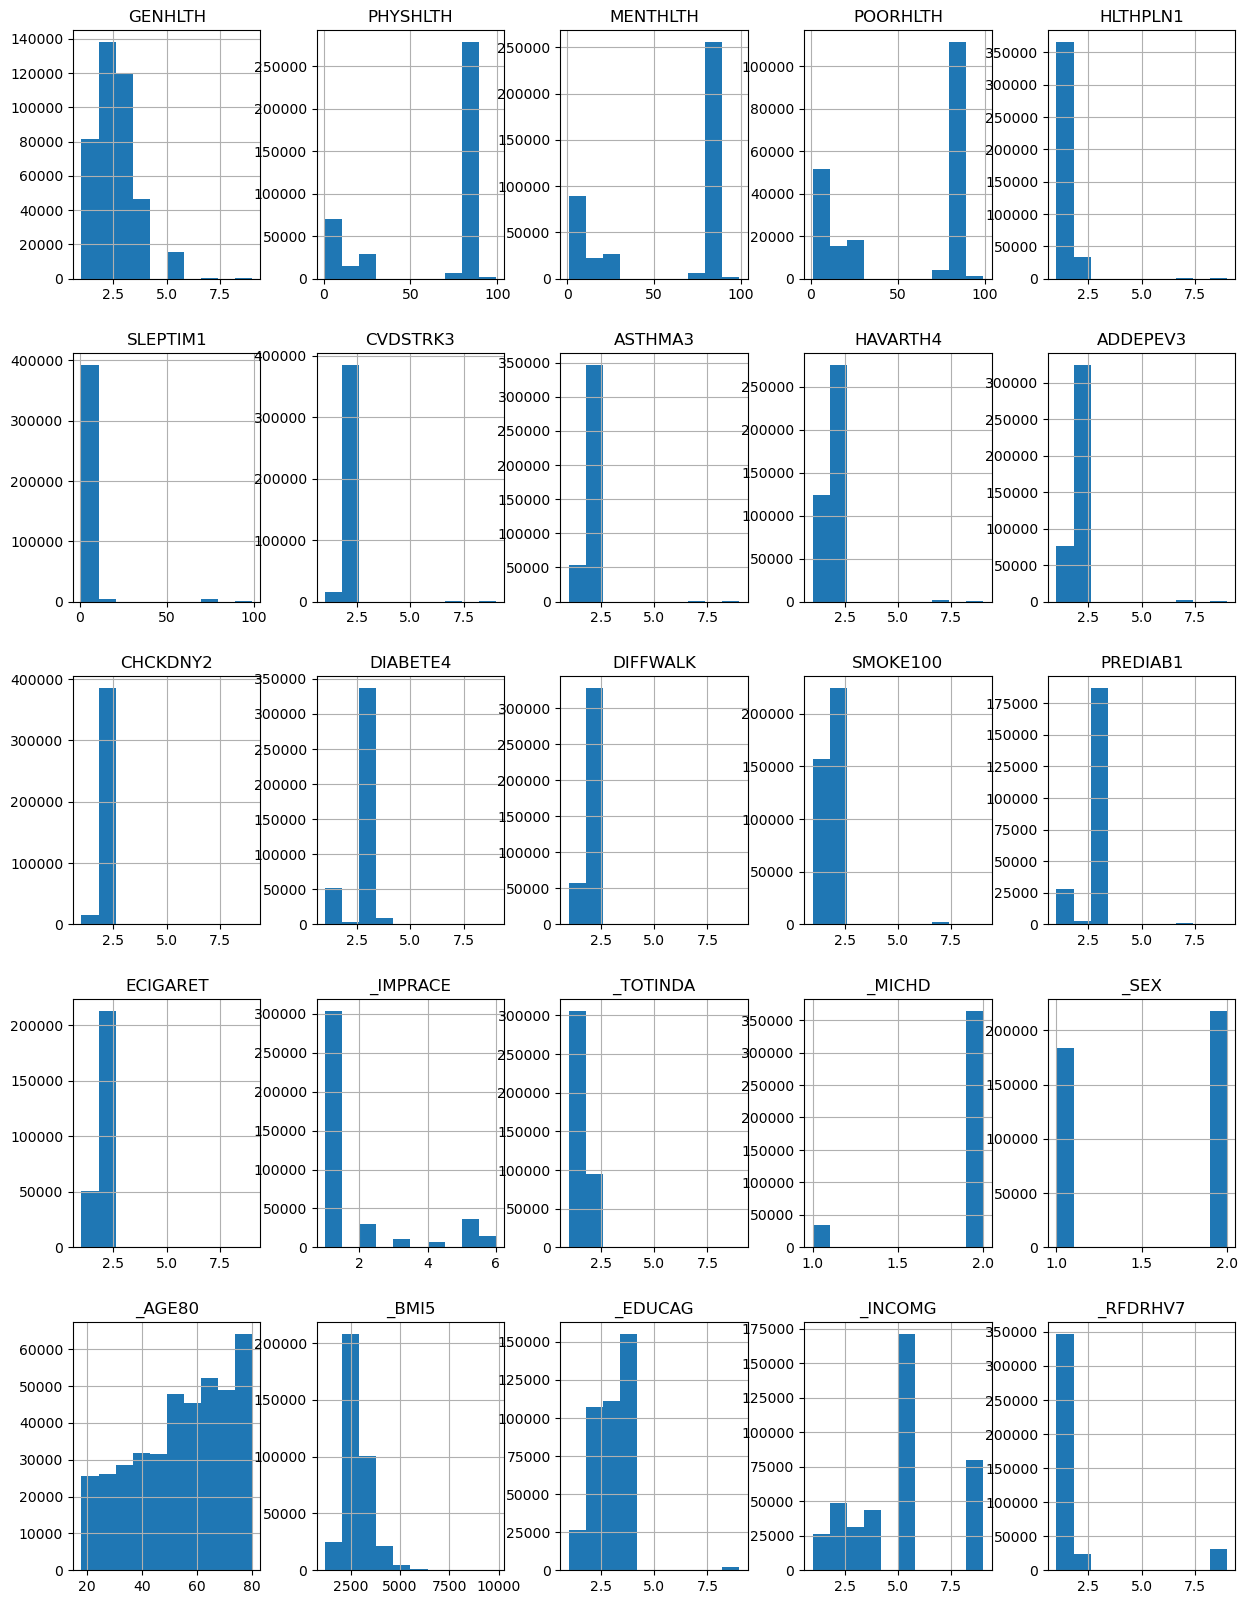

In [8]:
# Initial distribution
initial_hist = data.hist(figsize = (15,20))

### DIABETE4 <a class="anchor" id="DIABETE4"></a>
DIABETE4 is a measure of respondents diabetes state. In the BRFSS they were asked if they were "(Ever told) (you had) diabetes? (If ´Yes´ and respondent is female, ask ´Was this only when you were 
pregnant?"$^{12}$ The values shown in this column are coded as follows: \
<br>
1 = Diabetes \
2 = Gestational diabetes \
3 = No diabetes \
4 = Prediabetes \
7 = I Don't know \
9 = Refused \
<br>
Values coded 2, 7 and 9 will be removed as they do not represent our target. 4 (Prediabetes) will be combined into diabetes as our target, and all null values will be removed.

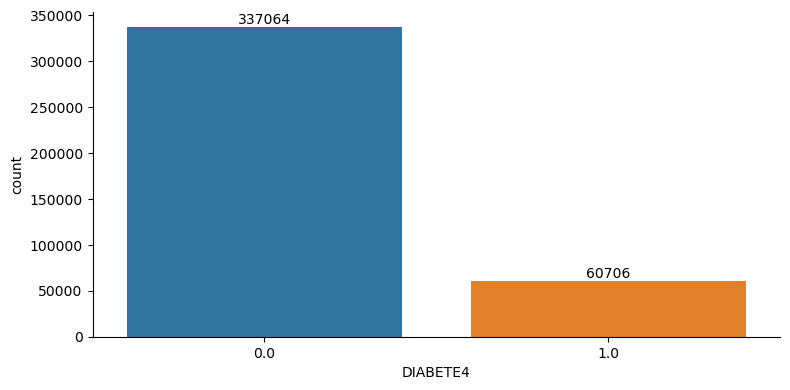

In [9]:
#DIABETE4
data['DIABETE4'] = data['DIABETE4'].replace(to_replace=[1, 4], value=1)
data['DIABETE4'] = data['DIABETE4'].replace(to_replace=[3], value=0)
data = data.loc[~((data['DIABETE4'] == 2.0) | (data['DIABETE4'] == 7.0) | (data['DIABETE4'] == 9.0)),:]
data = data.dropna(subset = ['DIABETE4'])
diab_plt = sns.catplot(data=data, kind='count', x='DIABETE4', height=4, aspect=2)
for ax in diab_plt.axes.flat:
    ax.bar_label(ax.containers[0])

PREDIAB1 is a measure of respondents prediabetes state. In the BRFSS they were asked "Have you ever been told by a doctor or other health professional that you have pre-diabetes or borderline diabetes? (If “Yes” and respondent is female, ask: “Was this only when you were pregnant?”)"$^{12}$ The values shown in this column are coded as follows: \
<br>
1 = Prediabetes \
2 = Gestational prediabetes \
3 = No prediabetes \
4 = Prediabetes \
7 = I Don't know \
9 = Refused \
<br>
We will not be changing the values as they are distributed in this feature, as we will combine it with the diabetes data, where all instances where diabetes is a value other than 1, will be replaced with 1 where the respondent indicated they have diabetes.

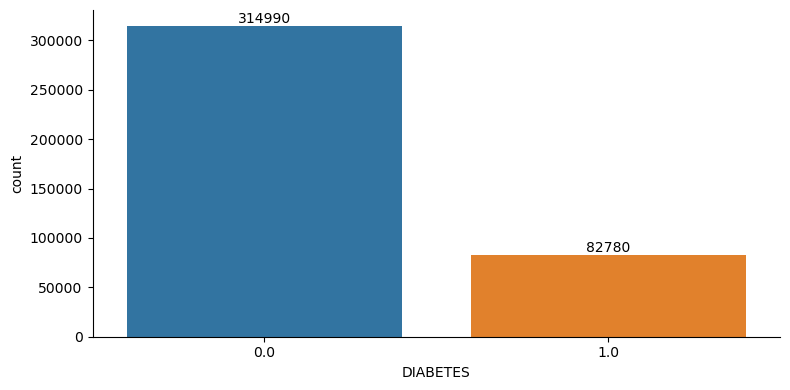

In [10]:
# DIABETE4 and PREDIAB1 combine to create label column. Replacing all 0 values in DIABETE4 where PREDIAB1 is 1
data['DIABETES'] = data['DIABETE4']
diab_prediab_cond = data.PREDIAB1 == 1
data.DIABETES[diab_prediab_cond] = data.PREDIAB1[diab_prediab_cond]
initial_diabprediab_plt = sns.catplot(data=data, kind='count', x='DIABETES', height=4, aspect=2)
for ax in initial_diabprediab_plt.axes.flat:
    ax.bar_label(ax.containers[0])

In [11]:
# Drop antiquated DIABETE4 and PREDIAB1 columns
data.drop(['DIABETE4', 'PREDIAB1'], inplace=True, axis=1)
data.head()

,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,SLEPTIM1,CVDSTRK3,ASTHMA3,HAVARTH4,ADDEPEV3,CHCKDNY2,DIFFWALK,SMOKE100,ECIGARET,_IMPRACE,_TOTINDA,_MICHD,_SEX,_AGE80,_BMI5,_EDUCAG,_INCOMG,_RFDRHV7,DIABETES
0,2.0,3.0,30.0,3.0,2.0,5.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,56.0,1660.0,4.0,1.0,1.0,1.0
1,3.0,88.0,88.0,NaN,1.0,7.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0,1.0,2.0,2.0,65.0,2918.0,4.0,9.0,9.0,1.0
2,3.0,88.0,88.0,NaN,1.0,7.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,65.0,NaN,3.0,5.0,1.0,0.0
3,1.0,88.0,88.0,NaN,1.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,80.0,NaN,2.0,9.0,1.0,0.0
4,2.0,88.0,88.0,NaN,1.0,7.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,80.0,2034.0,4.0,9.0,1.0,0.0


### GENHLTH <a class="anchor" id="GENHLTH"></a>
GENHLTH is a measure of respondents fellings about their general health. In the BRFSS they were asked "Would you say that in general your health is:"$^{12}$ The values shown in this column are coded as follows: \
<br>
1 = Excellent \
2 = Very Good \
3 = Good \
4 = Fair \
5 = Poor \
7 = Not sure \
9 = Refused \
<br>
We will be removing the rows with values of 7 and 0 which are essentially null values, and removing any true null values.

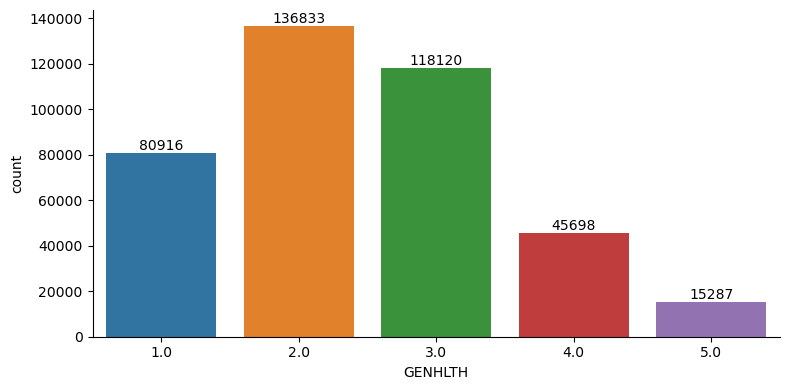

In [12]:
#GENHLTH
data = data.loc[~((data['GENHLTH'] == 7.0) | (data['GENHLTH'] == 9.0)),:]
data = data.dropna(subset = ['GENHLTH'])
cat_genhlth_plt = sns.catplot(data=data, kind='count', x='GENHLTH', height=4, aspect=2)
for ax in cat_genhlth_plt.axes.flat:
    ax.bar_label(ax.containers[0])

### PHYSHLTH <a class="anchor" id="PHYSHLTH"></a>
PHYSHLTH is a measure of respondents reported days in a month where they felt physically unwell. In the BRFSS they were asked "Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?"$^{12}$ The values shown in this column are coded as follows: \
<br>
1-30 = Number of days \
88 = None \
77 = Not sure \
99 = Refused \
<br>
We will be replacing values of 88 with 0 to indicate the true number of days, as well as removing values of 77 and 99 as they are essentially null values.

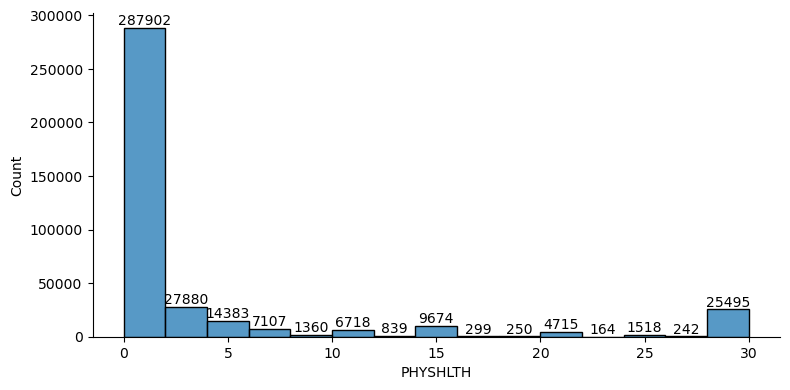

In [13]:
#PHYSHLTH
#Change none to 0, remove null
data['PHYSHLTH'] = data['PHYSHLTH'].replace(to_replace=[88], value=0)
data = data.loc[~((data['PHYSHLTH'] == 77.0) | (data['PHYSHLTH'] == 99.0)),:]
data = data.dropna(subset = ['PHYSHLTH'])
dist_physhlth_plt = sns.displot(data['PHYSHLTH'], bins=15, height=4, aspect=2)
for ax in dist_physhlth_plt.axes.flat:
    ax.bar_label(ax.containers[0])

### MENTHLTH <a class="anchor" id="MENTHLTH"></a>
MENTHLTH is a measure of respondents reported number of days of poor mental health. In the BRFSS they were asked "Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?"$^{12}$ The values shown in this column are coded as follows: \
<br>
1-30 = Number of days \
88 = None \
77 = Not sure \
99 = Refused \
<br>
We will be replacing values of 88 with 0 to indicate the true number of days, as well as removing values of 77 and 99 as they are essentially null values.

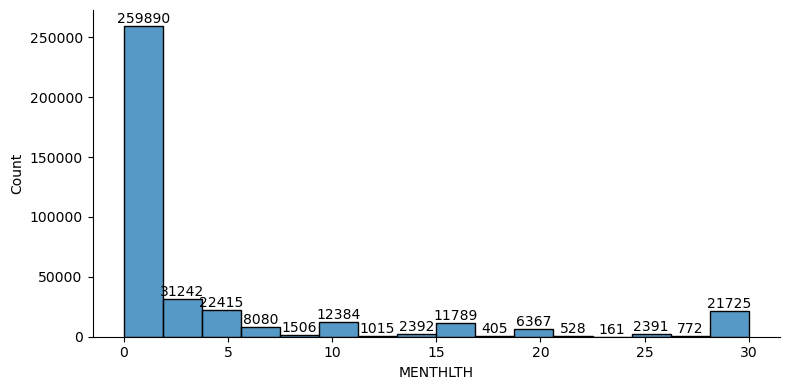

In [14]:
#MENTHLTH
#Change none to 0, remove null
data['MENTHLTH'] = data['MENTHLTH'].replace(to_replace=[88], value=0)
data = data.loc[~((data['MENTHLTH'] == 77.0) | (data['MENTHLTH'] == 99.0)),:]
data = data.dropna(subset = ['MENTHLTH'])
dist_menthlth_plt = sns.displot(data['MENTHLTH'], bins=16, height=4, aspect=2)
for ax in dist_menthlth_plt.axes.flat:
    ax.bar_label(ax.containers[0])

### POORHLTH <a class="anchor" id="POORHLTH"></a>
POORHLTH is a measure of respondents reported number of days they felt hindered by their poor health. In the BRFSS they were asked "During the past 30 days, for about how many days did poor physical or mental health keep you from doing your usual activities, such as self-care, work, or recreation?"$^{12}$ The values shown in this column are coded as follows: \
<br>
1-30 = Number of days \
88 = None \
77 = Not sure \
99 = Refused \
<br>
We will be removing this feature due to the high number of null values, seeing as we have other similar measures in GENHLTH, PHYSHLTH, and MENTHLTH.

In [15]:
#POORHLTH
#Drop due to high null values
data = data.drop('POORHLTH', axis=1)
data

,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,SLEPTIM1,CVDSTRK3,ASTHMA3,HAVARTH4,ADDEPEV3,CHCKDNY2,DIFFWALK,SMOKE100,ECIGARET,_IMPRACE,_TOTINDA,_MICHD,_SEX,_AGE80,_BMI5,_EDUCAG,_INCOMG,_RFDRHV7,DIABETES
0,2.0,3.0,30.0,2.0,5.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,56.0,1660.0,4.0,1.0,1.0,1.0
1,3.0,0.0,0.0,1.0,7.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0,1.0,2.0,2.0,65.0,2918.0,4.0,9.0,9.0,1.0
2,3.0,0.0,0.0,1.0,7.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,65.0,NaN,3.0,5.0,1.0,0.0
3,1.0,0.0,0.0,1.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,80.0,NaN,2.0,9.0,1.0,0.0
4,2.0,0.0,0.0,1.0,7.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,80.0,2034.0,4.0,9.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401953,3.0,0.0,0.0,2.0,6.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,5.0,1.0,2.0,2.0,45.0,2424.0,3.0,9.0,1.0,0.0
401954,3.0,0.0,0.0,1.0,12.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,5.0,2.0,2.0,2.0,29.0,3281.0,1.0,2.0,1.0,0.0
401955,3.0,0.0,0.0,1.0,8.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,5.0,1.0,2.0,2.0,80.0,4656.0,2.0,1.0,1.0,0.0
401956,3.0,0.0,0.0,1.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0,NaN,5.0,1.0,2.0,1.0,58.0,2661.0,4.0,9.0,1.0,0.0


### HLTHPLN1 <a class="anchor" id="HLTHPLN1"></a>
HLTHPLN1 is a measure of respondents healthcare coverage. In the BRFSS they were asked "Do you have any kind of health care coverage, including health insurance, prepaid plans such as HMOs, or government plans such as Medicare, or Indian Health Service?"$^{12}$ The values shown in this column are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be replacing the values of 2 with 0, and removing rows containing 7 and 9, as they are essentially null values.

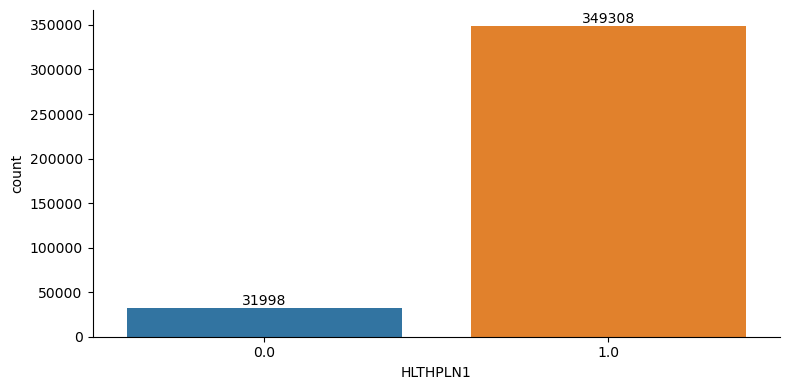

In [16]:
#HLTHPLN1
#Change no to 0, remove 7's and 9's
data['HLTHPLN1'] = data['HLTHPLN1'].replace(to_replace=[2], value=0)
data = data.loc[~((data['HLTHPLN1'] == 7.0) | (data['HLTHPLN1'] == 9.0)),:]
data = data.dropna(subset = ['HLTHPLN1'])
cat_hlthpln1_plt = sns.catplot(data=data, kind='count', x='HLTHPLN1', height=4, aspect=2)
for ax in cat_hlthpln1_plt.axes.flat:
    ax.bar_label(ax.containers[0])

### SLEPTIM1 <a class="anchor" id="SLEPTIM1"></a>
SLEPTIM1 is a measure of reported average sleep time in hours. In the BRFSS, respondents were asked "On average, how many hours of sleep do you get in a 24-hour period?"$^{12}$ Values are coded as follows: \
<br>
1 - 24 = Number of hours \
77 = Not sure \
99 = Refused \
<br>
We will be removing rows with 77 and 99 as they are essentially null values.

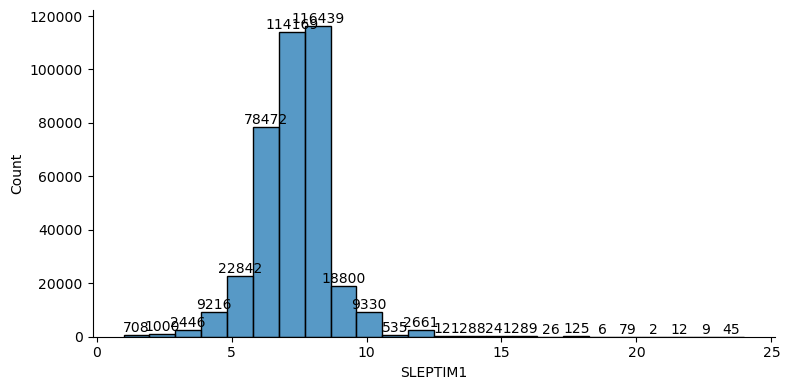

In [17]:
# SLEPTIM1
data = data.loc[~((data['SLEPTIM1'] == 77.0) | (data['SLEPTIM1'] == 99.0)),:]
data = data.dropna(subset = ['SLEPTIM1'])
initial_sleep_plt = sns.displot(data['SLEPTIM1'], bins=24, height=4, aspect=2)
for ax in initial_sleep_plt.axes.flat:
    ax.bar_label(ax.containers[0])

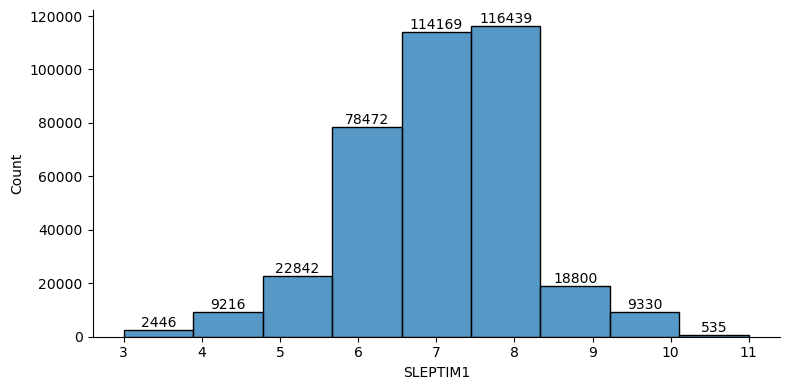

In [18]:
# Remove outliers
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = data['SLEPTIM1'].quantile(0.25)
Q3 = data['SLEPTIM1'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers in the 'SLEPTIM1' column
data.loc[(data['SLEPTIM1'] < lower_bound) | (data['SLEPTIM1'] > upper_bound), 'SLEPTIM1'] = None
data = data.dropna(subset = ['SLEPTIM1'])

# Plot distribution without outliers
sleep_plt = sns.displot(data['SLEPTIM1'], bins=9, height=4, aspect=2)
for ax in sleep_plt.axes.flat:
    ax.bar_label(ax.containers[0])

### CVDSTRK3 <a class="anchor" id="CVDSTRK3"></a>
SLEPTIM1 is a measure of reported strokes. In the BRFSS, respondents were asked "(Ever told) (you had) a stroke."$^{12}$ Values are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be changing 2 to 0, and removing rows with 7 and 9 as they are essentially null values.

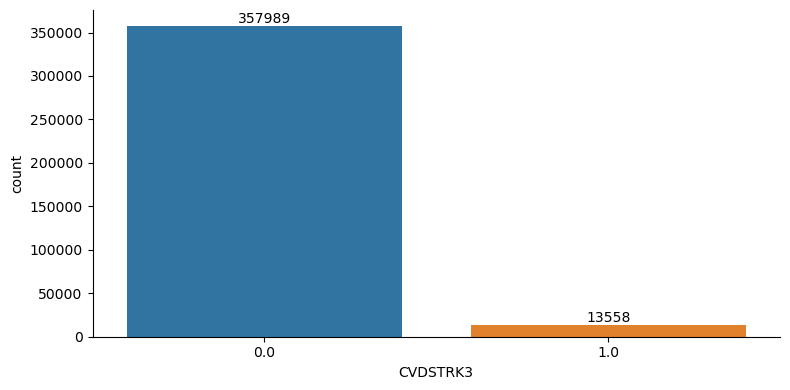

In [19]:
# CVDSTRK3
data['CVDSTRK3'] = data['CVDSTRK3'].replace(to_replace=[2], value=0)
data = data.loc[~((data['CVDSTRK3'] == 7.0) | (data['CVDSTRK3'] == 9.0)),:]
data = data.dropna(subset = ['CVDSTRK3'])
binary_cvdstrk_hist = sns.catplot(data=data, kind='count', x='CVDSTRK3', height=4, aspect=2)
for ax in binary_cvdstrk_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### ASTHMA3 <a class="anchor" id="ASTHMA3"></a>
SLEPTIM1 is a measure of reported asthma. In the BRFSS, respondents were asked "(Ever told) (you had) asthma?"$^{12}$ Values are coded as follows: \
<br>
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be changing 2 to 0, and removing rows with 7 and 9 as they are essentially null values.

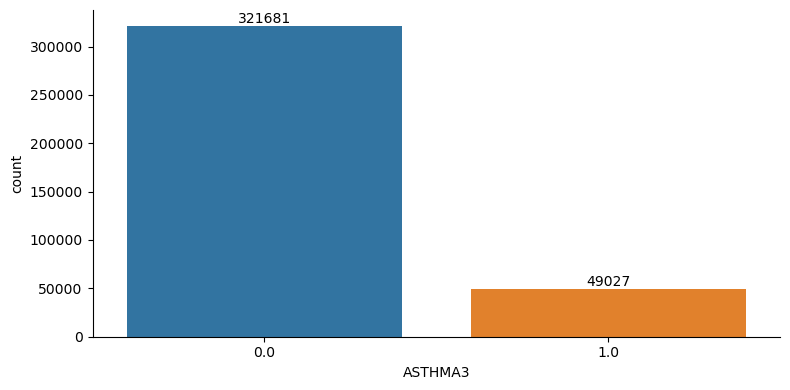

In [20]:
# ASTHMA3
data['ASTHMA3'] = data['ASTHMA3'].replace(to_replace=[2], value=0)
data = data.loc[~((data['ASTHMA3'] == 7.0) | (data['ASTHMA3'] == 9.0)),:]
data = data.dropna(subset = ['ASTHMA3'])
binary_asthma_hist = sns.catplot(data=data, kind='count', x='ASTHMA3', height=4, aspect=2)
for ax in binary_asthma_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### HAVARTH4 <a class="anchor" id="HAVARTH4"></a>
SLEPTIM1 is a measure of reported arthritis and joint issues. In the BRFSS, respondents were asked "(Ever told) (you had) some form of arthritis, rheumatoid arthritis, gout, lupus, or fibromyalgia? (Arthritis 
diagnoses include: rheumatism, polymyalgia rheumatica; osteoarthritis (not osteporosis); tendonitis, bursitis, bunion, 
tennis elbow; carpal tunnel syndrome, tarsal tunnel syndrome; joint infection, etc.)"$^{12}$ Values are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be changing 2 to 0, and removing rows with 7 and 9 as they are essentially null values.

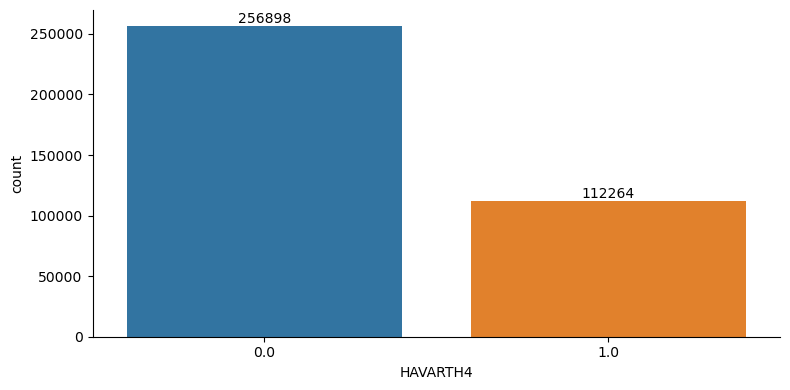

In [21]:
# HAVARTH4
data['HAVARTH4'] = data['HAVARTH4'].replace(to_replace=[2], value=0)
data = data.loc[~((data['HAVARTH4'] == 7.0) | (data['HAVARTH4'] == 9.0)),:]
data = data.dropna(subset = ['HAVARTH4'])
binary_arth_hist = sns.catplot(data=data, kind='count', x='HAVARTH4', height=4, aspect=2)
for ax in binary_arth_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### ADDEPEV3 <a class="anchor" id="ADDEPEV3"></a>
ADDEPEV3 is a measure of respondents reported depression. In the BRFSS they were asked "(Ever told) (you had) a depressive disorder (including depression, major depression, dysthymia, or minor 
depression)? "$^{12}$ The values shown in this column are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be changing 2 to 0, and removing rows with 7 and 9 as they are essentially null values.

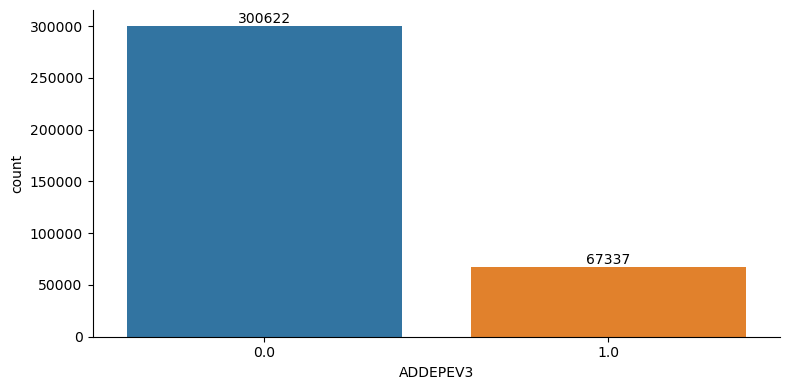

In [22]:
#ADDEPEV3
#Change no to 0, remove 7 and 9
data['ADDEPEV3'] = data['ADDEPEV3'].replace(to_replace=[2], value=0)
data = data.loc[~((data['ADDEPEV3'] == 7.0) | (data['ADDEPEV3'] == 9.0)),:]
data = data.dropna(subset = ['ADDEPEV3'])
addepev3_hist = sns.catplot(data=data, kind='count', x='ADDEPEV3', height=4, aspect=2)
for ax in addepev3_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### CHCKDNY2 <a class="anchor" id="CHCKDNY2"></a>
CHCKDNY2 is a measure of respondents reported kidney disease. In the BRFSS they were asked "Not including kidney stones, bladder infection or incontinence, were you eer told you had kidney disease? "$^{12}$ The values shown in this column are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be changing 2 to 0, and removing rows with 7 and 9 as they are essentially null values.

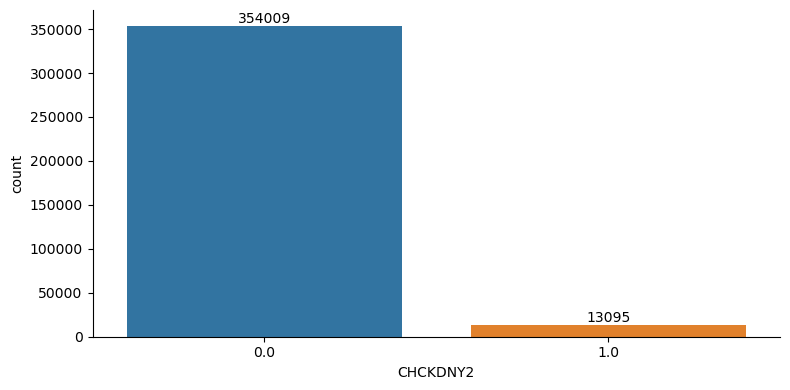

In [23]:
#CHCKDNY2
#Change 2 to 0, remove 7 and 9
data['CHCKDNY2'] = data['CHCKDNY2'].replace(to_replace=[2], value=0)
data = data.loc[~((data['CHCKDNY2'] == 7.0) | (data['CHCKDNY2'] == 9.0)),:]
data = data.dropna(subset = ['CHCKDNY2'])
binary_chckdny2_hist = sns.catplot(data=data, kind='count', x='CHCKDNY2', height=4, aspect=2)
for ax in binary_chckdny2_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### DIFFWALK <a class="anchor" id="DIFFWALK"></a>
DIFFWALK is a measure of reported walking difficulty. In the BRFSS, respondents were asked "Do you have serious difficulty walking or climbing stairs?"$^{12}$ Values are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be changing 2 to 0, and removing rows with 7 and 9 as they are essentially null values.

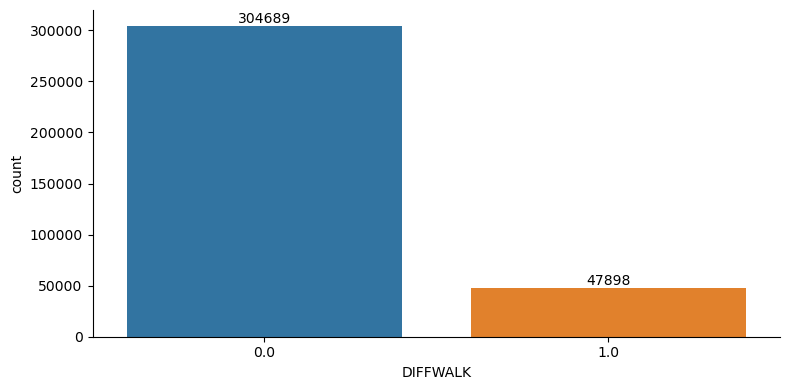

In [24]:
# DIFFWALK
data['DIFFWALK'] = data['DIFFWALK'].replace(to_replace=[2], value=0)
data = data.loc[~((data['DIFFWALK'] == 7.0) | (data['DIFFWALK'] == 9.0)),:]
data = data.dropna(subset = ['DIFFWALK'])
binary_walk_hist = sns.catplot(data=data, kind='count', x='DIFFWALK', height=4, aspect=2)
for ax in binary_walk_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### SMOKE100 <a class="anchor" id="SMOKE100"></a>
SMOKE100 is a measure of reported cigarette smoking history. In the BRFSS, respondents were asked "Have you smoked at least 100 cigarettes in your entire life?"$^{12}$ Values are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be changing 2 to 0, and removing rows with 7 and 9 as they are essentially null values.

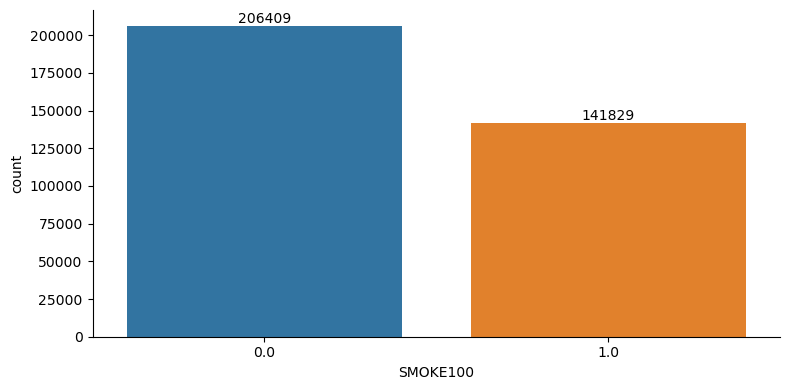

In [25]:
# SMOKE100
data['SMOKE100'] = data['SMOKE100'].replace(to_replace=[2], value=0)
data = data.loc[~((data['SMOKE100'] == 7.0) | (data['SMOKE100'] == 9.0)),:]
data = data.dropna(subset = ['SMOKE100'])
binary_smoke_hist = sns.catplot(data=data, kind='count', x='SMOKE100', height=4, aspect=2)
for ax in binary_smoke_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### ECIGARET <a class="anchor" id="ECIGARET"></a>
ECIGARET is a measure of reported e-cigarette smoking history. In the BRFSS, respondents were asked "Have you ever used an e-cigarette or other electronic vaping product, even just one time, in your entire life?"$^{12}$ Values are coded as follows: \
<br>
1 = Yes \
2 = No \
7 = Not sure \
9 = Refused \
<br>
We will be combining this variable with SMOKE100 due to the high number of null values present.

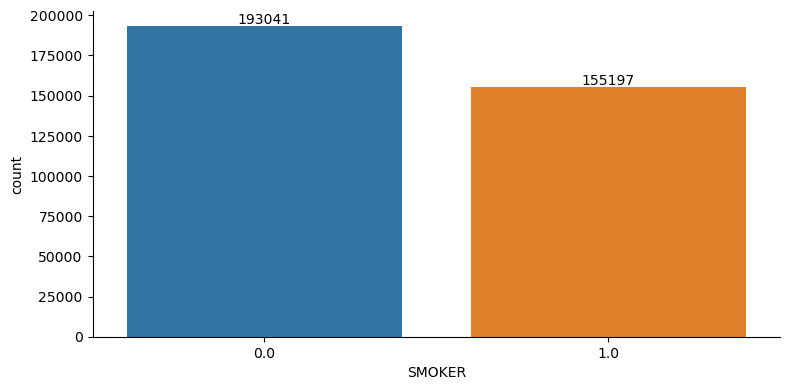

In [26]:
# Combine with smoke100, similar to diab_prediab
data['SMOKER'] = data['SMOKE100']
smoke_ecig_cond = data.ECIGARET == 1
data.SMOKER[smoke_ecig_cond] = data.ECIGARET[smoke_ecig_cond]
initial_smoker_plt = sns.catplot(data=data, kind='count', x='SMOKER', height=4, aspect=2)
for ax in initial_smoker_plt.axes.flat:
    ax.bar_label(ax.containers[0])

In [27]:
# Drop antiquated SMOKE100 and ECIGARET columns
data.drop(['SMOKE100', 'ECIGARET'], inplace=True, axis=1)
data

,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,SLEPTIM1,CVDSTRK3,ASTHMA3,HAVARTH4,ADDEPEV3,CHCKDNY2,DIFFWALK,_IMPRACE,_TOTINDA,_MICHD,_SEX,_AGE80,_BMI5,_EDUCAG,_INCOMG,_RFDRHV7,DIABETES,SMOKER
0,2.0,3.0,30.0,0.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,56.0,1660.0,4.0,1.0,1.0,1.0,1.0
2,3.0,0.0,0.0,1.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,65.0,NaN,3.0,5.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,80.0,NaN,2.0,9.0,1.0,0.0,0.0
4,2.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,80.0,2034.0,4.0,9.0,1.0,0.0,0.0
5,4.0,20.0,30.0,1.0,8.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,66.0,2658.0,2.0,3.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401950,1.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,2.0,2.0,22.0,2222.0,3.0,1.0,1.0,0.0,0.0
401951,4.0,7.0,0.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,1.0,1.0,60.0,2741.0,1.0,9.0,1.0,1.0,1.0
401952,2.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,2.0,1.0,37.0,2984.0,3.0,1.0,1.0,0.0,1.0
401953,3.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,2.0,2.0,45.0,2424.0,3.0,9.0,1.0,0.0,0.0


### _IMPRACE<a class="anchor" id="_IMPRACE"></a>
_IMPRACE is a measure of reported ethnicity. In the BRFSS, listed as "Imputed race/ethnicity value (This value is the reported race/ethnicity or an imputed race/ethnicity, if the respondent refused to give a race/ethnicity. The value of the imputed race/ethnicity will be the most common race/ethnicity response for that region of the state)"$^{12}$ Values are coded as follows: \
<br>
1 = White, Non-Hispanic \
2 = Black, Non-Hispanic \
3 = Asian, Non-Hispanic \
4 = Native, Non-Hispanic \
5 = Hispanic, Non-Hispanic \
6 = Other, Non-Hispanic \
<br>
We will not need to make any further alterations as this data contains no coded null values.

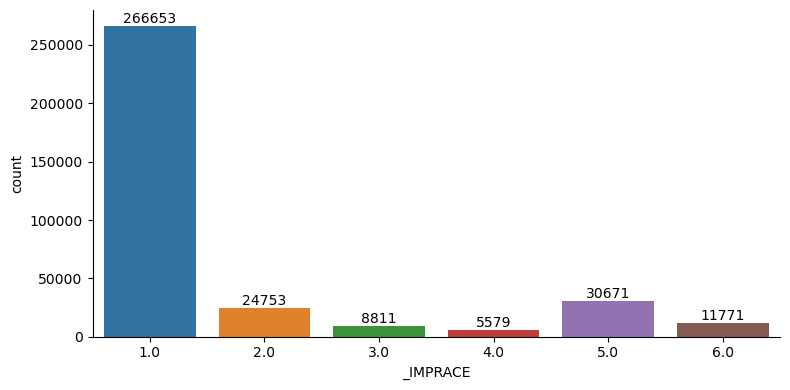

In [28]:
# _IMPRACE
initial_race_hist = sns.catplot(data=data, kind='count', x='_IMPRACE', height=4, aspect=2)
for ax in initial_race_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### _TOTINDA<a class="anchor" id="_TOTINDA"></a>
_TOTINDA is a measure of reported exercise. In the BRFSS, it is listed as "Adults who reported doing physical activity or exercise during the past 30 days other than their regular job"$^{12}$ Values are coded as follows: \
<br>
1 = Yes \
2 = No \
9 = Not sure / Refused \
<br>
We will be changing 2 to 0, and removing rows with 9 as they are essentially null values.

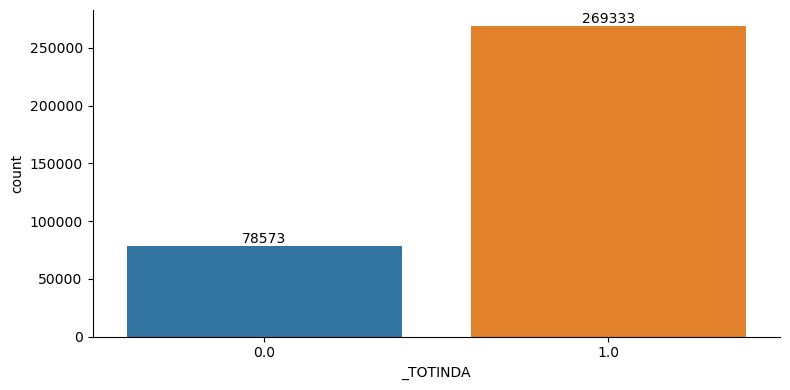

In [29]:
# _TOTINDA
data['_TOTINDA'] = data['_TOTINDA'].replace(to_replace=[2], value=0)
data = data.loc[~((data['_TOTINDA'] == 9.0)),:]
data = data.dropna(subset = ['_TOTINDA'])
binary_exercise_hist = sns.catplot(data=data, kind='count', x='_TOTINDA', height=4, aspect=2)
for ax in binary_exercise_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### _MICHD<a class="anchor" id="_MICHD"></a>
_MICHD is a measure of reported heart disease and heart attack. In the BRFSS, it is listed as "Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)"$^{12}$ Values are coded as follows: \
<br>
1 = Yes \
2 = No \
<br>
We will be changing 2 to 0.

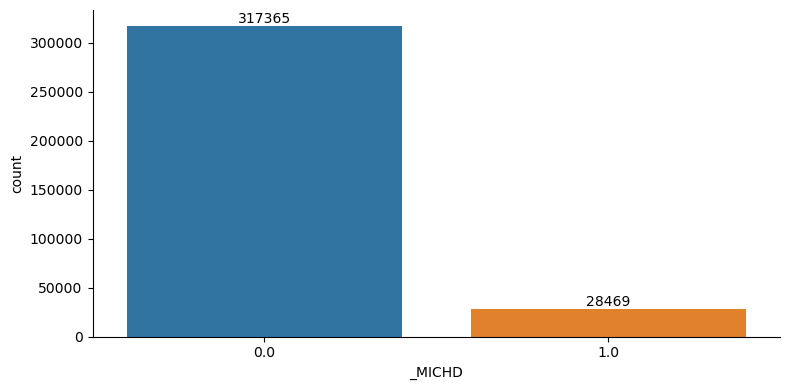

In [30]:
# _MICHD
data['_MICHD'] = data['_MICHD'].replace(to_replace=[2], value=0)
data = data.dropna(subset = ['_MICHD'])
binary_heart_hist = sns.catplot(data=data, kind='count', x='_MICHD', height=4, aspect=2)
for ax in binary_heart_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### _SEX<a class="anchor" id="_SEX"></a>
_SEX is a measure of reported sex at birth. In the BRFSS, it is listed as "Calculated sex variable"$^{12}$ Values are coded as follows: \
<br>
1 = Male \
2 = Female \
<br>
We will be changing 2 to 0.

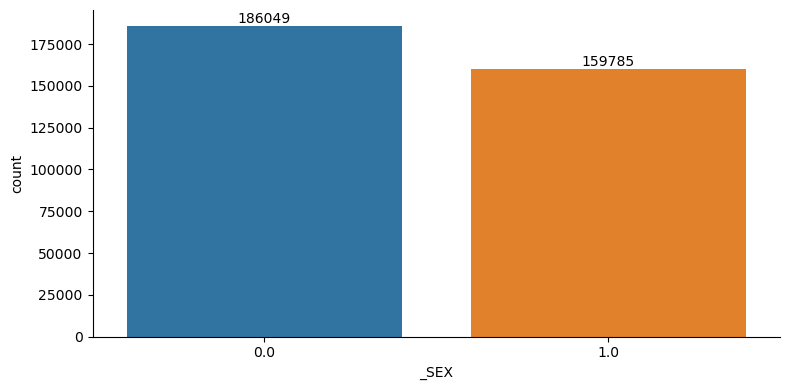

In [31]:
data['_SEX'] = data['_SEX'].replace(to_replace=[2], value=0)
binary_sex_hist = sns.catplot(data=data, kind='count', x='_SEX', height=4, aspect=2)
for ax in binary_sex_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### _AGE80<a class="anchor" id="_AGE80"></a>
_AGE80 is a measure of reported respondent age. In the BRFSS, it is listed as "Imputed Age value collapsed above 80"$^{12}$ Values are coded as follows: \
<br>
18-79 = Imputed age 18-79 \
80 = Imputed age 80 or older

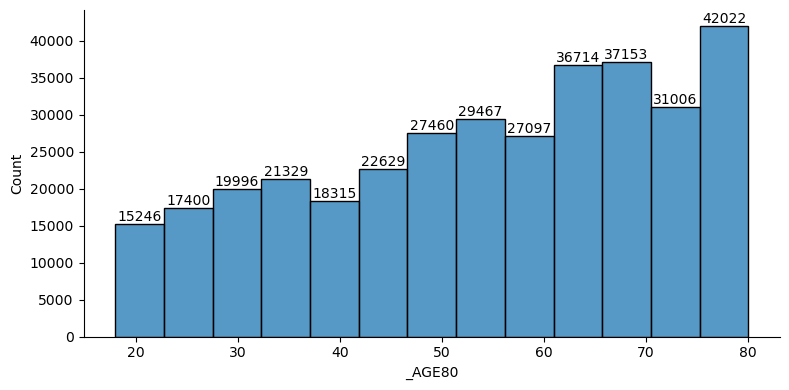

In [32]:
# _AGE80
initial_age_hist = sns.displot(data['_AGE80'], bins=13, height=4, aspect=2)
for ax in initial_age_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### _BMI5<a class="anchor" id="_BMI5"></a>
_BMI5 is a measure of reported body mass index (BMI) with two implied decimal places. In the BRFSS, it is listed as "Body Mass Index (BMI)"$^{12}$ Values are coded as follows: \
<br>
1 - 9999 = BMI with two implied decimal places \
<br>
We will be changing the calculated values to display as BMI normally would, with two decimal places.

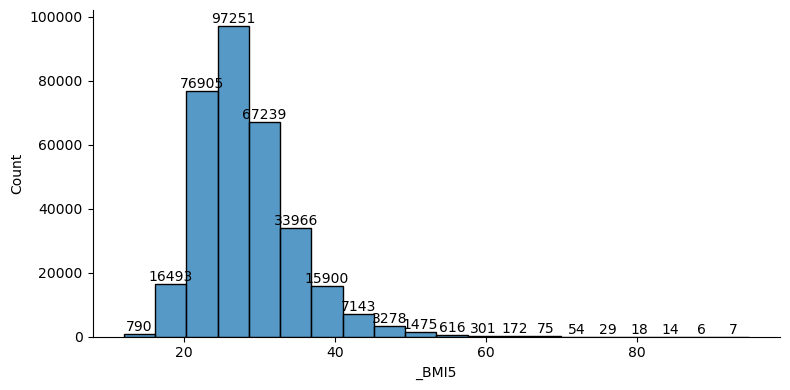

In [33]:
# _BMI5
data = data.dropna(subset = ['_BMI5'])
data['_BMI5'] = data['_BMI5'].div(100)
initial_bmi_hist = sns.displot(data['_BMI5'], bins=20, height=4, aspect=2)
for ax in initial_bmi_hist.axes.flat:
    ax.bar_label(ax.containers[0])

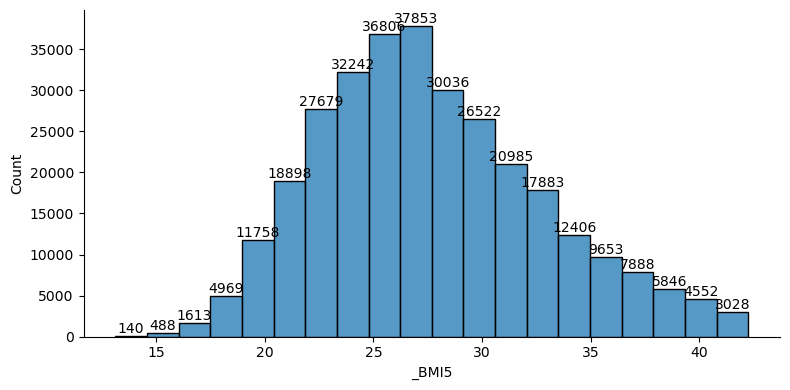

In [34]:
# Remove outliers
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = data['_BMI5'].quantile(0.25)
Q3 = data['_BMI5'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers in the 'SLEPTIM1' column
data.loc[(data['_BMI5'] < lower_bound) | (data['_BMI5'] > upper_bound), '_BMI5'] = None
data = data.dropna(subset = ['_BMI5'])

# Plot distribution without outliers
bmi_plt = sns.displot(data['_BMI5'], bins=20, height=4, aspect=2)
for ax in bmi_plt.axes.flat:
    ax.bar_label(ax.containers[0])

### _EDUCAG<a class="anchor" id="_EDUCAG"></a>
_EDUCAG is a measure of reported education received. In the BRFSS, it is listed as "Level of education completed"$^{12}$ Values are coded as follows: \
<br>
1  = Did not graduate High School \
2 = Graduated High School \
3 = Attended College or Technical School \
4 = Graduated from College or Technical School \
9 = Refused \
<br>
We will be removing rows with 9 as they are essentially null values.

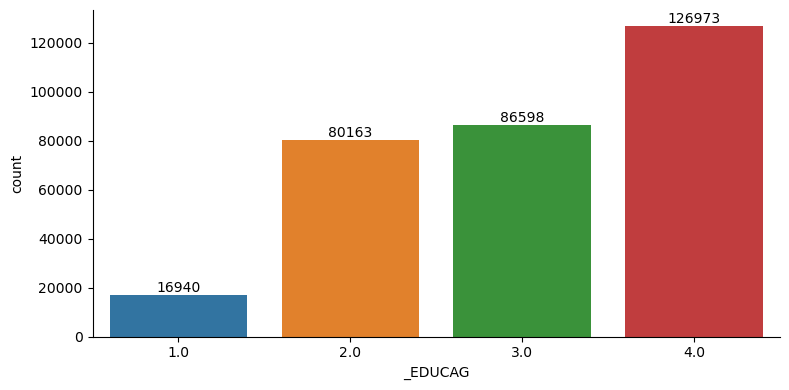

In [35]:
# Deal with category 9
data = data.loc[~((data['_EDUCAG'] == 9.0)),:]
data = data.dropna(subset = ['_EDUCAG'])
cat_education_hist = sns.catplot(data=data, kind='count', x='_EDUCAG', height=4, aspect=2)
for ax in cat_education_hist.axes.flat:
    ax.bar_label(ax.containers[0])

### _INCOMG<a class="anchor" id="_INCOMG"></a>
_INCOMG is a measure of reported yearly income. In the BRFSS, it is listed as "Income categories"$^{12}$ Values are coded as follows: \
<br>
1 = Less than 15,000 \
2 = 15,000 to less than 25,000 \
3 = 25,000 to less than 35,000 \
4 = 35,000 to less than 50,000 \
5 = 50,000 or more \
9 = Not sure \
<br>
Due to the high number of category 9, which are essentially null values, we will not be including income.

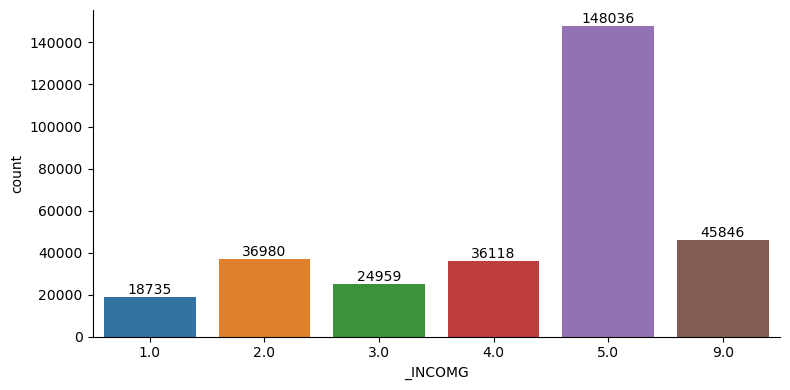

In [36]:
# _INCOMG
initial_income_hist = sns.catplot(data=data, kind='count', x='_INCOMG', height=4, aspect=2)
for ax in initial_income_hist.axes.flat:
    ax.bar_label(ax.containers[0])
# 1 = <$15,000, 2 = $15,000-$24,999, 3 = $25,000-34,999, 4 = $35,000-$49,999, 5 = >$50,000, 9 = idk/refused/missing

In [37]:
# _INCOMG
# Deal with category 9
data = data.drop('_INCOMG', axis=1)
data

,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,SLEPTIM1,CVDSTRK3,ASTHMA3,HAVARTH4,ADDEPEV3,CHCKDNY2,DIFFWALK,_IMPRACE,_TOTINDA,_MICHD,_SEX,_AGE80,_BMI5,_EDUCAG,_RFDRHV7,DIABETES,SMOKER
0,2.0,3.0,30.0,0.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,56.0,16.60,4.0,1.0,1.0,1.0
4,2.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,80.0,20.34,4.0,1.0,0.0,0.0
5,4.0,20.0,30.0,1.0,8.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,66.0,26.58,2.0,1.0,1.0,1.0
6,3.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,75.0,24.21,2.0,1.0,0.0,0.0
7,4.0,15.0,10.0,1.0,6.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,69.0,26.57,2.0,9.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401949,4.0,7.0,30.0,1.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0,5.0,1.0,1.0,0.0,52.0,32.12,1.0,9.0,1.0,0.0
401950,1.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,22.0,22.22,3.0,1.0,0.0,0.0
401951,4.0,7.0,0.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,1.0,60.0,27.41,1.0,1.0,1.0,1.0
401952,2.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,37.0,29.84,3.0,1.0,0.0,1.0


### _RFDRHV7 <a class="anchor" id="_RFDRHV7"></a>
_RFDRHV7 is a measure of respondents heavy alcohol consumption. In the BRFSS it is listed as "Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)"$^{12}$ The values are coded as follows: \
<br>
1 = No \
2 = Yes \
9 = Not sure / Refused \
<br>
We will be replacing 1 with 0, 2 with 1, and removing rows with 9 as they are essentially null values.

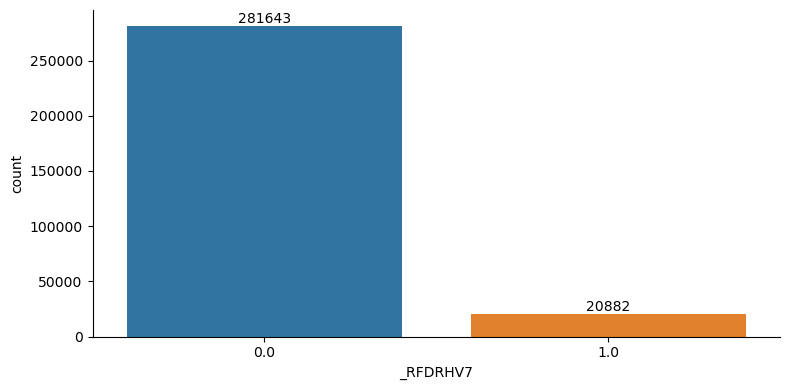

In [38]:
#_RFDRHV7
#Change 1 to 0, 2 to 1, and remove 9
data['_RFDRHV7'] = data['_RFDRHV7'].replace(to_replace=[1], value=0)
data['_RFDRHV7'] = data['_RFDRHV7'].replace(to_replace=[2], value=1)
data = data.loc[~((data['_RFDRHV7'] == 9.0)),:]
data = data.dropna(subset = ['_RFDRHV7'])
binary_drink_hist = sns.catplot(data=data, kind='count', x='_RFDRHV7', height=4, aspect=2)
for ax in binary_drink_hist.axes.flat:
    ax.bar_label(ax.containers[0])

In [39]:
# Rename Columns
data.rename(columns = {'SLEPTIM1':'SLEEP', 'CVDSTRK3':'STROKE', 'ASTHMA3':'ASTHMA', 'HAVARTH4':'ARTHRITIS',
                       'ADDEPEV3':'DEPRESSION', 'CHCKDNY2':'KIDNEY', 'DIFFWALK':'WALK_ISSUE', '_IMPRACE':'ETHNICITY',
                       '_TOTINDA':'EXERCISE', '_MICHD':'HEART_DISEASE', '_SEX':'SEX', '_AGE80':'AGE', '_BMI5':'BMI',
                       '_EDUCAG':'EDUCATION', '_RFDRHV7':'DRINK'
                        }, inplace = True)

In [40]:
# Change column order
data = data[sorted(data.columns)]
label_column = data.pop('DIABETES')
data.insert(0, 'DIABETES', label_column)
data = data.reset_index(drop=True)
data

,DIABETES,AGE,ARTHRITIS,ASTHMA,BMI,DEPRESSION,DRINK,EDUCATION,ETHNICITY,EXERCISE,GENHLTH,HEART_DISEASE,HLTHPLN1,KIDNEY,MENTHLTH,PHYSHLTH,SEX,SLEEP,SMOKER,STROKE,WALK_ISSUE
0,1.0,56.0,1.0,1.0,16.60,1.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,30.0,3.0,0.0,5.0,1.0,0.0,0.0
1,0.0,80.0,0.0,0.0,20.34,0.0,0.0,4.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0
2,1.0,66.0,1.0,1.0,26.58,0.0,0.0,2.0,1.0,1.0,4.0,0.0,1.0,0.0,30.0,20.0,1.0,8.0,1.0,0.0,0.0
3,0.0,75.0,0.0,0.0,24.21,0.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
4,0.0,41.0,0.0,0.0,23.71,0.0,0.0,4.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,28.0,0.0,8.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302520,0.0,64.0,0.0,0.0,23.38,0.0,0.0,4.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
302521,0.0,22.0,0.0,0.0,22.22,0.0,0.0,3.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
302522,1.0,60.0,0.0,1.0,27.41,0.0,0.0,1.0,5.0,0.0,4.0,1.0,1.0,0.0,0.0,7.0,1.0,6.0,1.0,0.0,1.0
302523,0.0,37.0,0.0,1.0,29.84,0.0,0.0,3.0,5.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0


In [41]:
# Check for any null values remaining in the dataset
data.isnull().sum()

DIABETES         0
AGE              0
ARTHRITIS        0
ASTHMA           0
BMI              0
DEPRESSION       0
DRINK            0
EDUCATION        0
ETHNICITY        0
EXERCISE         0
GENHLTH          0
HEART_DISEASE    0
HLTHPLN1         0
KIDNEY           0
MENTHLTH         0
PHYSHLTH         0
SEX              0
SLEEP            0
SMOKER           0
STROKE           0
WALK_ISSUE       0
dtype: int64

### Distribution vs Diabetes State<a class="anchor" id="eda2"></a>

In this section we will provide an overview of the remaining cleaned features, as well as plot their distributions against the target variable, and examine any correlation between features.

In [42]:
# Prepare features for model use
# Split labels, binary data, categorical data, and numerical data
label = data[['DIABETES']].copy()
binary = data[['ARTHRITIS', 'ASTHMA', 'EXERCISE', 'HEART_DISEASE', 'KIDNEY', 'DEPRESSION', 'HLTHPLN1', 'SEX', 'SMOKER',
               'STROKE', 'WALK_ISSUE', 'DRINK']].copy()
categorical = data[['GENHLTH','ETHNICITY', 'EDUCATION']].copy()
numerical = data[['PHYSHLTH','MENTHLTH','SLEEP', 'AGE', 'BMI']].copy()

#### Binary Features<a class="anchor" id="eda2.1"></a>

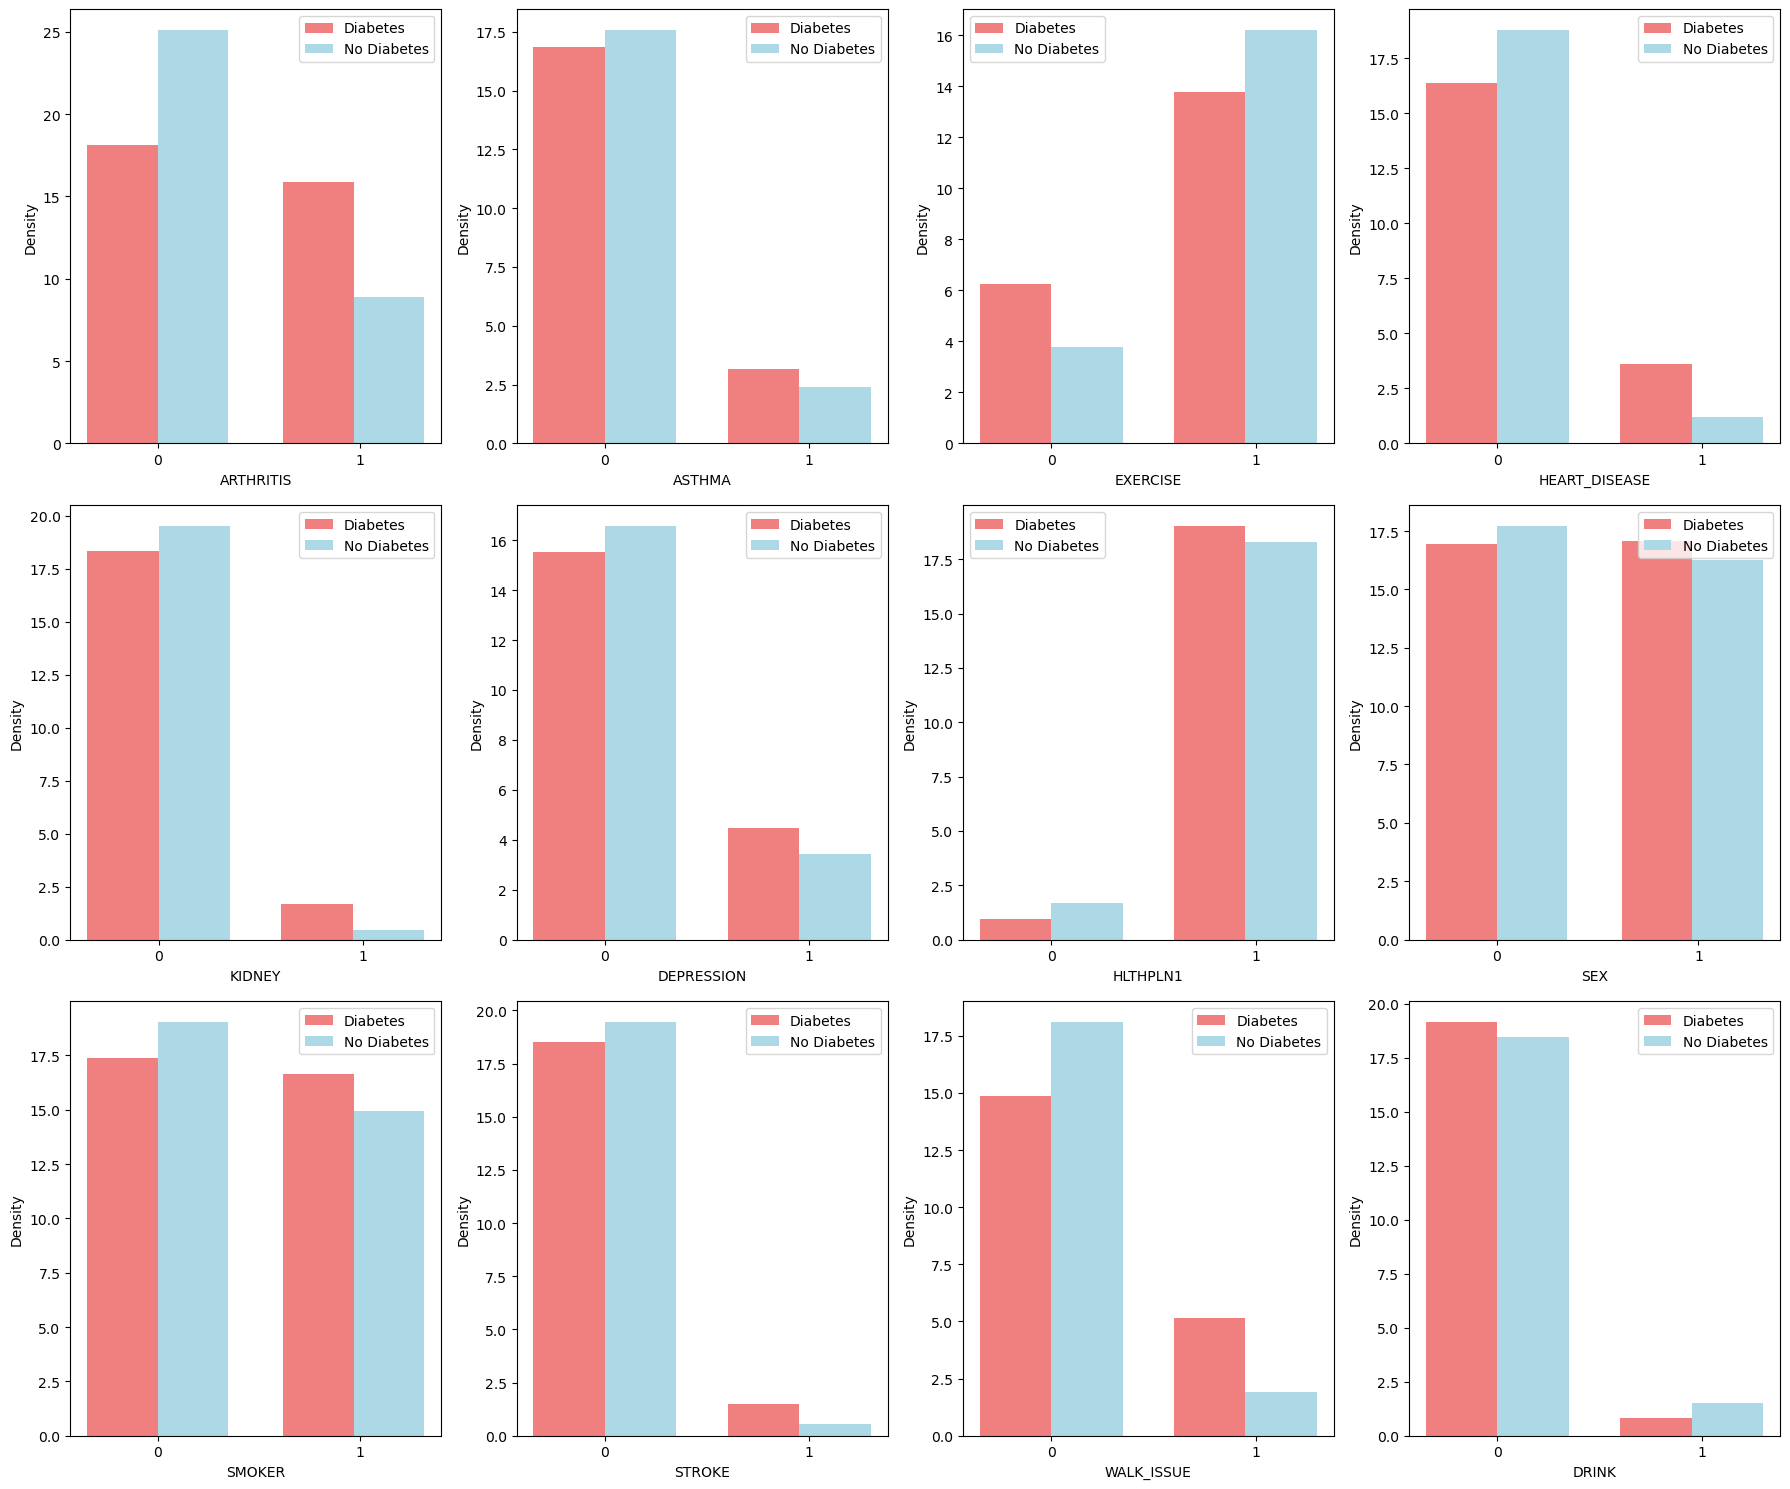

In [43]:
# Plot binary variables
plot_binary_variables(binary, label)

#### Categorical Features<a class="anchor" id="eda2.2"></a>

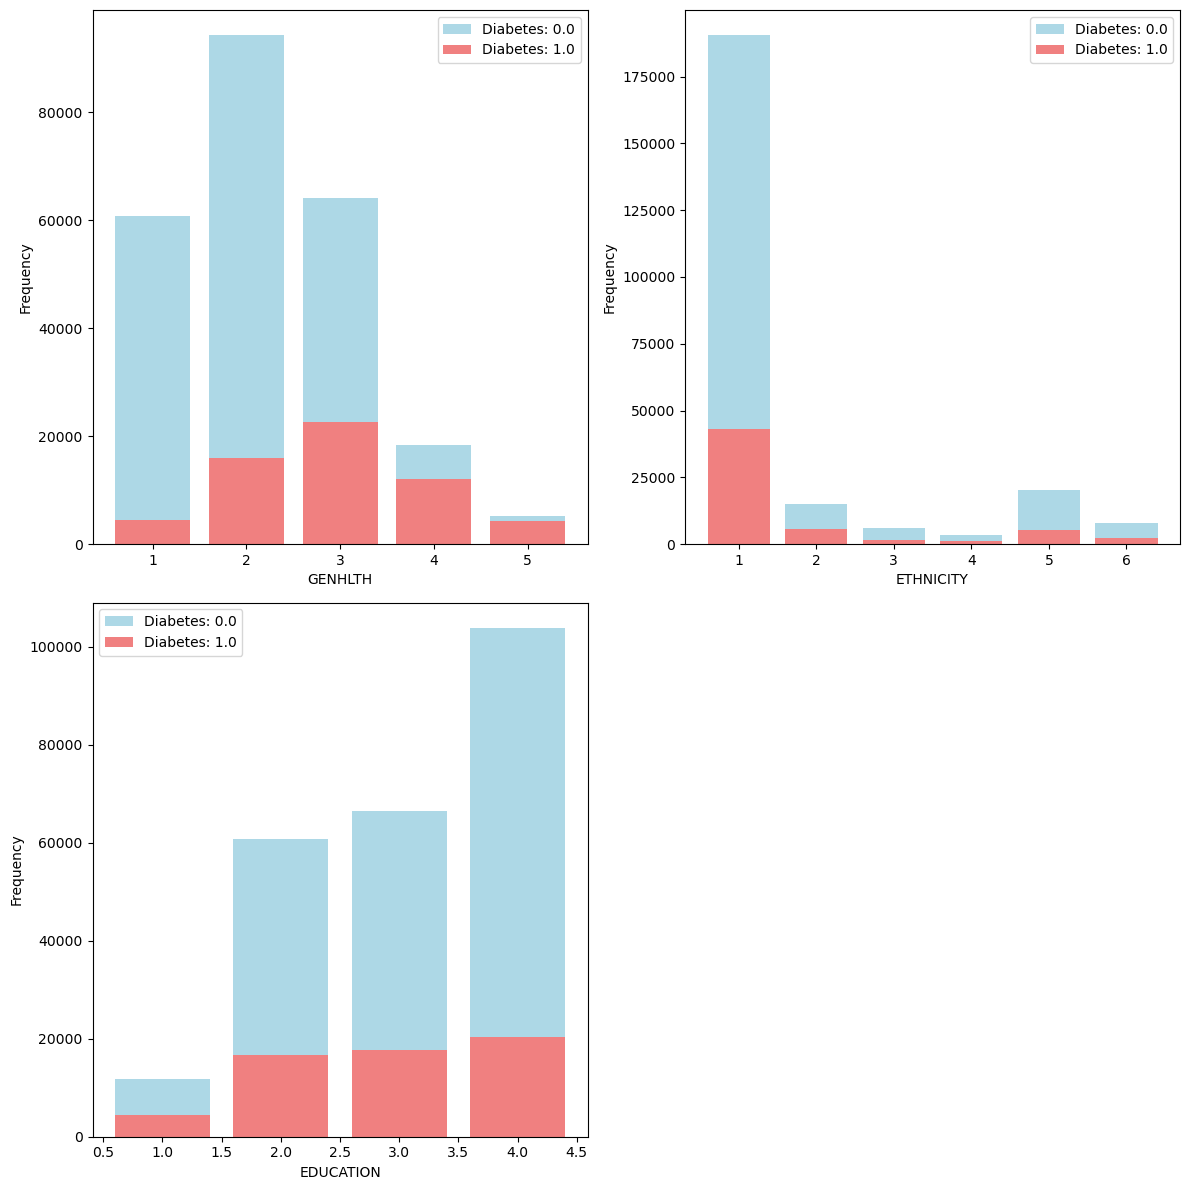

In [44]:
# Plot categorical features
plot_categorical_variables(categorical, label)

#### Numerical Features<a class="anchor" id="eda2.3"></a>

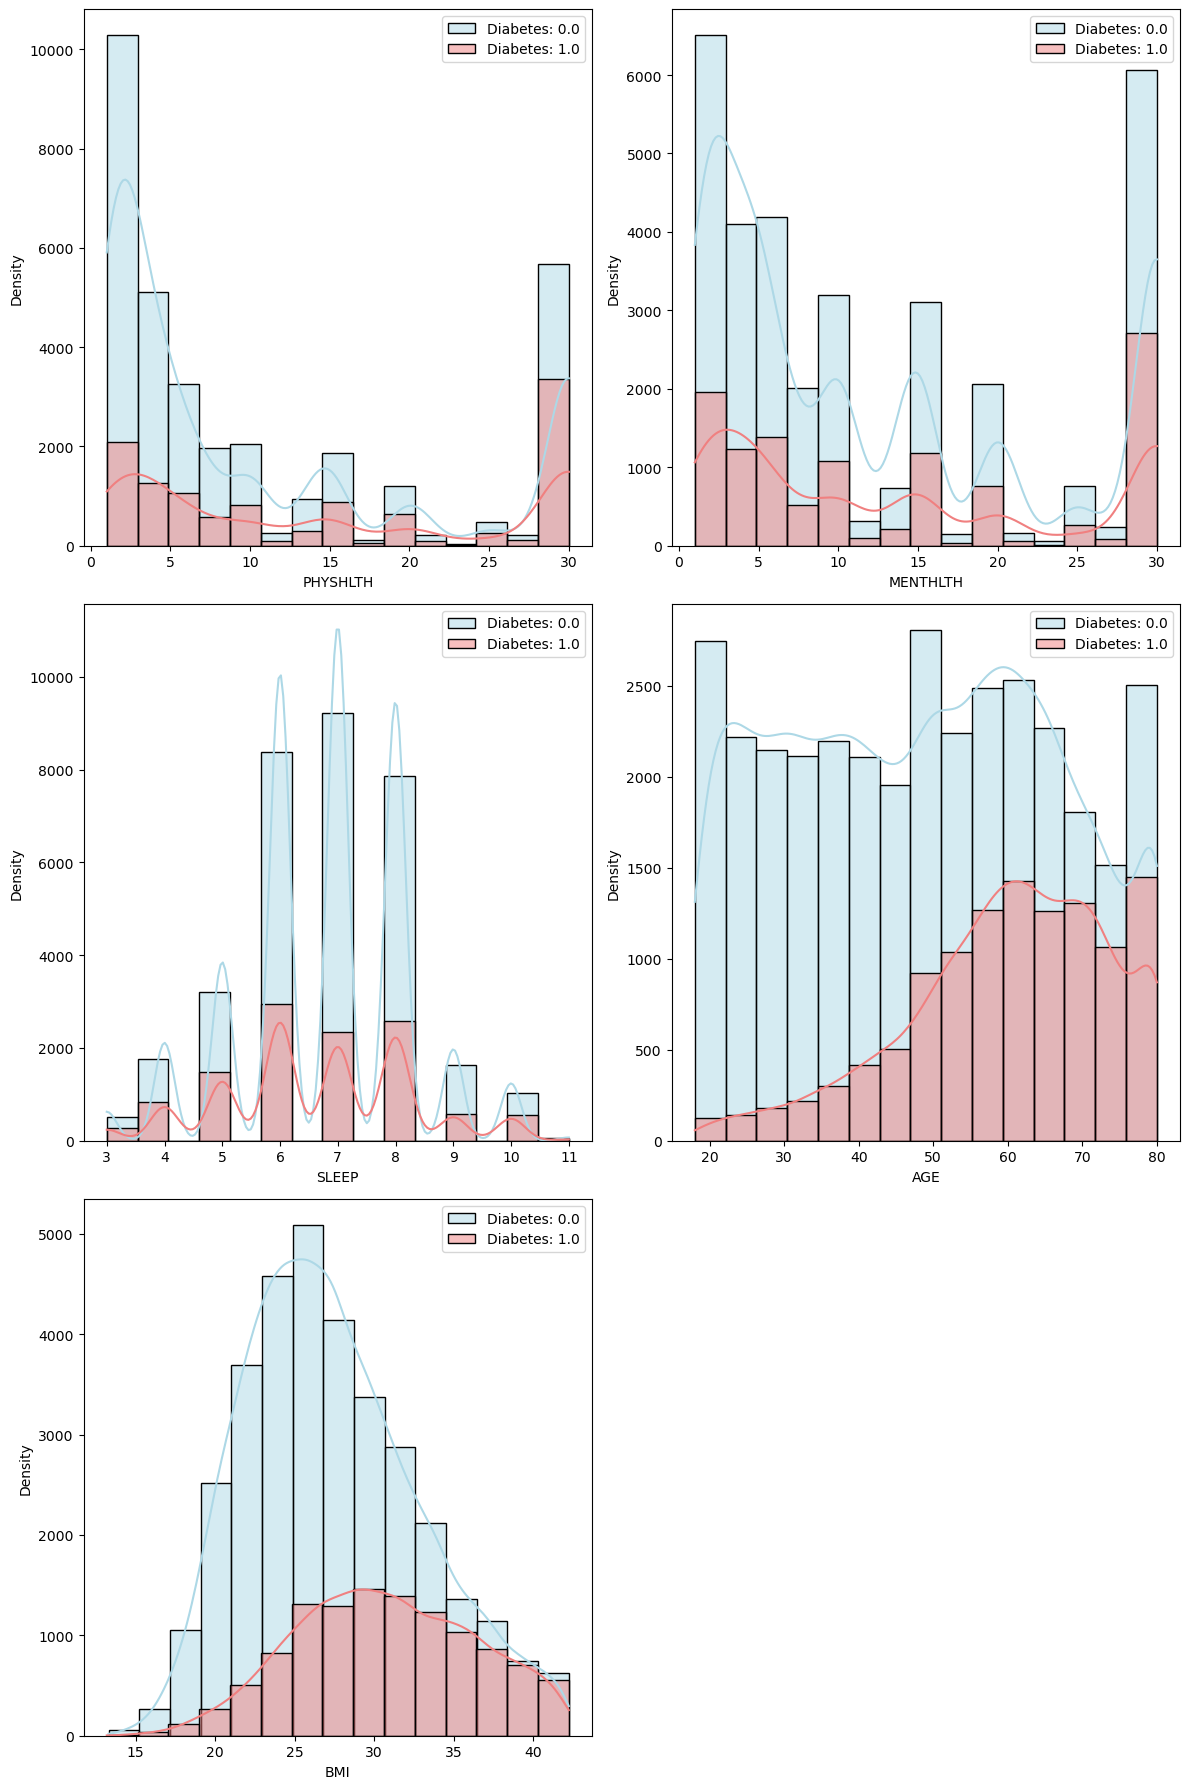

In [45]:
# Plot numerical features
numerical_omitted = numerical.loc[~((data['PHYSHLTH'] == 0) | (data['MENTHLTH'] == 0)),:]
features = ['PHYSHLTH', 'MENTHLTH', 'SLEEP', 'AGE', 'BMI']
plot_numerical_variables(numerical_omitted, label, features)

In [46]:
def calculate_zero_values(numerical, label, features):
    for feature in features:
        zero_values_count = []
        for diabetes_label in sorted(label['DIABETES'].unique()):
            subset = numerical[label['DIABETES'] == diabetes_label][feature]
            num_zeros = len(subset[subset == 0])
            zero_values_count.append(num_zeros)
        
        zero_values_text = "0 Value Counts for " + feature + ": " + " | ".join([f"Diabetes {diabetes_label}: {count}" for diabetes_label, count in zip(sorted(label['DIABETES'].unique()), zero_values_count)])
        print(zero_values_text)

features = ['PHYSHLTH', 'MENTHLTH']
calculate_zero_values(numerical, label, features)

0 Value Counts for PHYSHLTH: Diabetes 0.0: 180681 | Diabetes 1.0: 36954
0 Value Counts for MENTHLTH: Diabetes 0.0: 157527 | Diabetes 1.0: 39515


### Correlation Matrix<a class="anchor" id="eda3"></a>

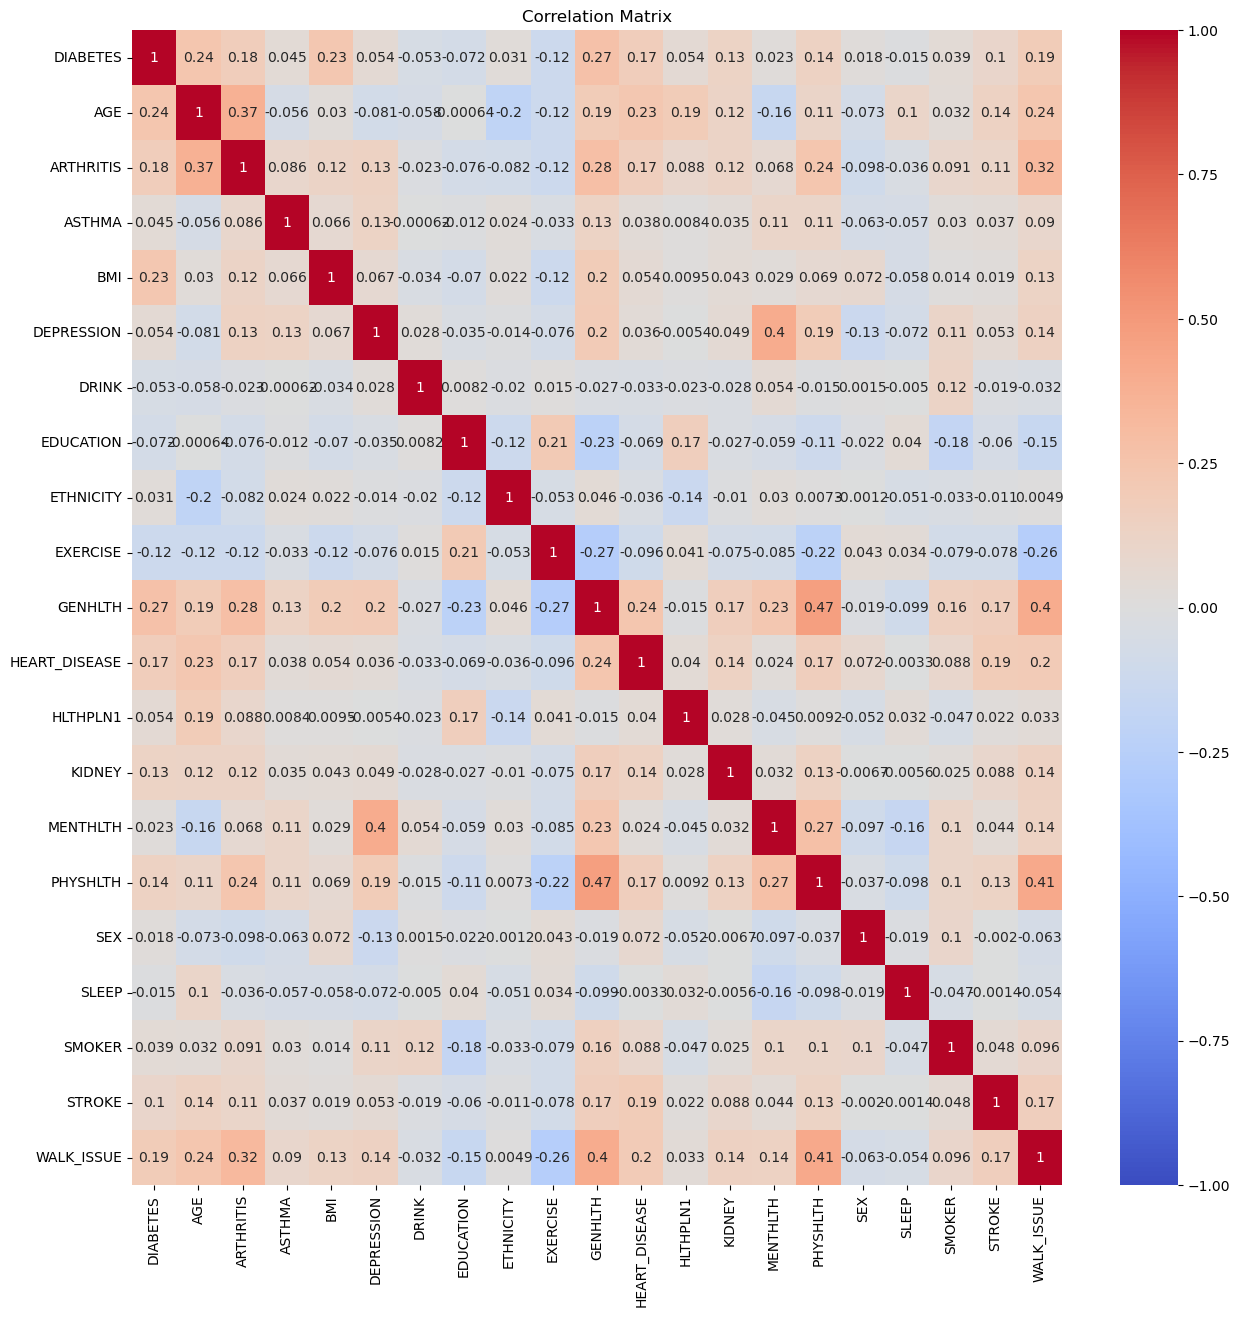

In [47]:
# Correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Preprocessing and Splitting the Data <a class="anchor" id="eighth-bullet"></a>
In this section we will be one hot encoding the categorical variables using get_dummies and using a log transformation on the numerical variables. Once the features are preprocessed, we will recombine them and split the data into training, testing, and validation sets. After this, we will use a min/max scaler on the split data, and then oversample the training set to deal with the class imbalance in our target.

In [48]:
# OHE categorical, non-binaryfeatures (ethnicity, education)
categorical_dummies = pd.get_dummies(categorical, columns=['GENHLTH','ETHNICITY', 'EDUCATION'], drop_first=False)
categorical_dummies # Confirm they are all there

,GENHLTH_1.0,GENHLTH_2.0,GENHLTH_3.0,GENHLTH_4.0,GENHLTH_5.0,ETHNICITY_1.0,ETHNICITY_2.0,ETHNICITY_3.0,ETHNICITY_4.0,ETHNICITY_5.0,ETHNICITY_6.0,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302520,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
302521,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
302522,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
302523,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [49]:
# Log transform numerical variables
log_numerical = np.log1p(numerical)
log_numerical # Confirm it worked

,PHYSHLTH,MENTHLTH,SLEEP,AGE,BMI
0,1.386294,3.433987,1.791759,4.043051,2.867899
1,0.000000,0.000000,2.079442,4.394449,3.060583
2,3.044522,3.433987,2.197225,4.204693,3.317091
3,0.000000,0.000000,1.945910,4.330733,3.227241
4,3.367296,0.000000,2.197225,3.737670,3.207208
...,...,...,...,...,...
302520,0.000000,0.000000,1.945910,4.174387,3.193763
302521,0.000000,0.000000,2.197225,3.135494,3.145014
302522,2.079442,0.000000,1.945910,4.110874,3.346741
302523,0.000000,0.000000,1.791759,3.637586,3.428813


In [50]:
# re-combine feature data
features_transformed = pd.concat([log_numerical, binary, categorical_dummies], axis=1)
features_transformed # Confirm they are all there

,PHYSHLTH,MENTHLTH,SLEEP,AGE,BMI,ARTHRITIS,ASTHMA,EXERCISE,HEART_DISEASE,KIDNEY,DEPRESSION,HLTHPLN1,SEX,SMOKER,STROKE,WALK_ISSUE,DRINK,GENHLTH_1.0,GENHLTH_2.0,GENHLTH_3.0,GENHLTH_4.0,GENHLTH_5.0,ETHNICITY_1.0,ETHNICITY_2.0,ETHNICITY_3.0,ETHNICITY_4.0,ETHNICITY_5.0,ETHNICITY_6.0,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0
0,1.386294,3.433987,1.791759,4.043051,2.867899,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0.000000,0.000000,2.079442,4.394449,3.060583,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,3.044522,3.433987,2.197225,4.204693,3.317091,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.000000,0.000000,1.945910,4.330733,3.227241,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,3.367296,0.000000,2.197225,3.737670,3.207208,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302520,0.000000,0.000000,1.945910,4.174387,3.193763,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
302521,0.000000,0.000000,2.197225,3.135494,3.145014,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
302522,2.079442,0.000000,1.945910,4.110874,3.346741,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
302523,0.000000,0.000000,1.791759,3.637586,3.428813,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [51]:
# Split the data
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

X_train_full, X_test, y_train_full, y_test = train_test_split(features_transformed, label, test_size=test_ratio,
                                                              random_state=42, stratify=label, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,
                                                      test_size=validation_ratio/(train_ratio+test_ratio), random_state=42)

In [52]:
# Scale the data
scaler = MinMaxScaler().set_output(transform="pandas") # Output data frame
X_train = scaler.fit_transform(X_train) # Fit on train data
X_test = scaler.transform(X_test) # Apply to test
X_valid = scaler.transform(X_valid) # Apply to validation

In [53]:
y_train.value_counts() # Examine class imbalance

DIABETES
0.0         194310
1.0          47709
dtype: int64

In [54]:
# Upsampling to balance classes
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [55]:
y_train_ros.value_counts() # Confirm classes are balanced

DIABETES
0.0         194310
1.0         194310
dtype: int64

## Train 5 Basic Models <a class="anchor" id="basic"></a>
In this section we will be training 5 model with basic hyperparameters and evaluating their performance. These 5 models are:

A Logistic Regression Model \
A Random Forest Classifier \
An XGBoost Classifier \
A Hist Gradient Boosting Classifier \
An Artificial Neural Network

For each of these models, we will examine their ROC curves and AUC values, Their precision/recall curves, their confusion matrix, and performance metrics including: recall, f2 score, precision, f1 score, and accuracy.

Because of the goals of our classifer and the class imbalance present in the test, validation, and real-world data; we want to place more emphasis on recall, and f2 score. This is because the cost associated with a false negative is higher, as an individual who may have diabetes or prediabetes, and is told they may not, is less likely to seek medical advice and improve their health outcomes.
### Logistic Regression Model <a class="anchor" id="lrm"></a>

In [56]:
# Train model and make predictions
lrm_initial = LogisticRegression(class_weight={0:1,1:1.1}, random_state=42, max_iter=300, multi_class='ovr')
lrm_initial.fit(X_train_ros, y_train_ros)
lrm_initial_pred = lrm_initial.predict(X_test)

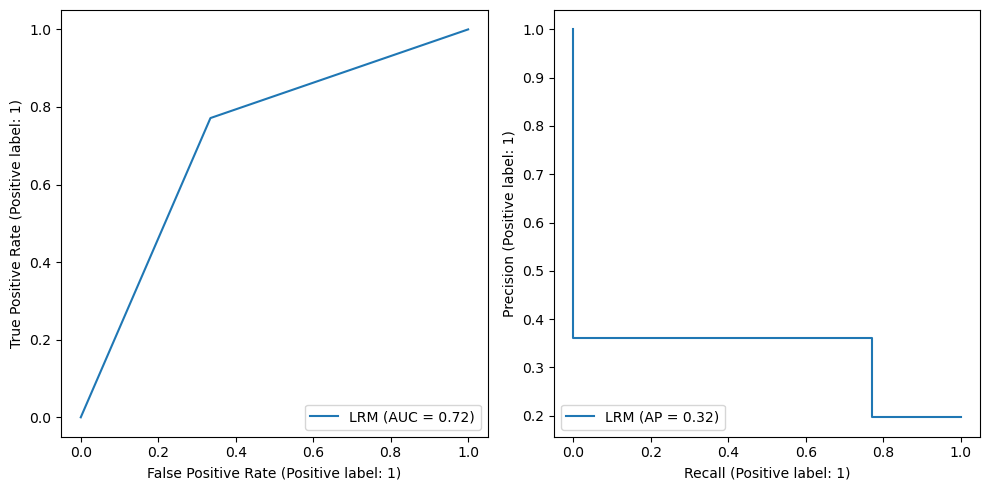

In [100]:
# ROC and Precision/Recall Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
roc_display = RocCurveDisplay.from_predictions(y_test, lrm_initial_pred, name='LRM', ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, lrm_initial_pred, name='LRM', ax=ax2)
plt.tight_layout()

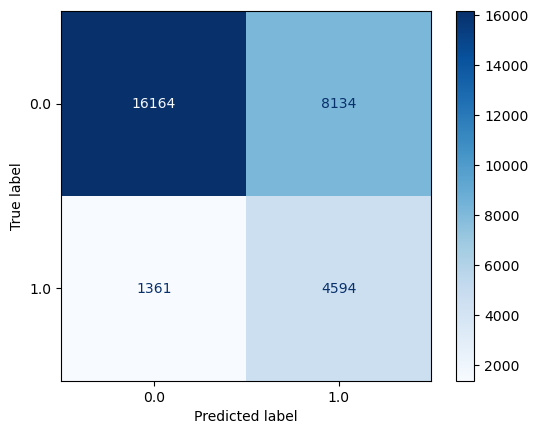

In [58]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, lrm_initial_pred, cmap='Blues')

In [59]:
# Performance metrics
# Compute accuracy score for LRM
lrm_initial_accuracy = accuracy_score(y_test, lrm_initial_pred)
print("Logistic Regression Model Accuracy:", lrm_initial_accuracy)

# Compute f1 score for LRM
lrm_initial_f1 = f1_score(y_test, lrm_initial_pred)
print("Logistic Regression Model F1:", lrm_initial_f1)

# Compute f2 score for LRM
lrm_initial_f2 = fbeta_score(y_test, lrm_initial_pred, beta=2)
print("Logistic Regression Model F2:", lrm_initial_f2)

# Compute precision score for LRM
lrm_initial_precision = precision_score(y_test, lrm_initial_pred)
print("Logistic Regression Model Precision:", lrm_initial_precision)

# Compute recall score for LRM
lrm_initial_recall = recall_score(y_test, lrm_initial_pred)
print("Logistic Regression Model Recall:", lrm_initial_recall)

Logistic Regression Model Accuracy: 0.686146828413711
Logistic Regression Model F1: 0.49178397473639135
Logistic Regression Model F2: 0.6284885629856627
Logistic Regression Model Precision: 0.3609365179132621
Logistic Regression Model Recall: 0.7714525608732158


### Random Forest Classifier <a class="anchor" id="rfc"></a>

In [60]:
# Train model and make predictions
rfc_initial = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=15, random_state=42,
                                     class_weight='balanced_subsample')
rfc_initial.fit(X_train_ros, y_train_ros)
rfc_initial_pred = rfc_initial.predict(X_test)

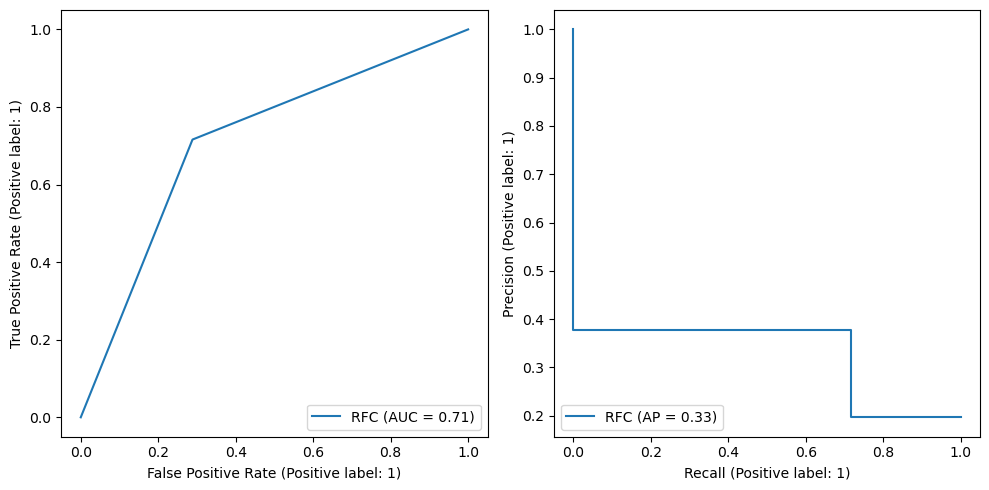

In [98]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
roc_display = RocCurveDisplay.from_predictions(y_test, rfc_initial_pred, name='RFC', ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, rfc_initial_pred, name='RFC', ax=ax2)
plt.tight_layout()

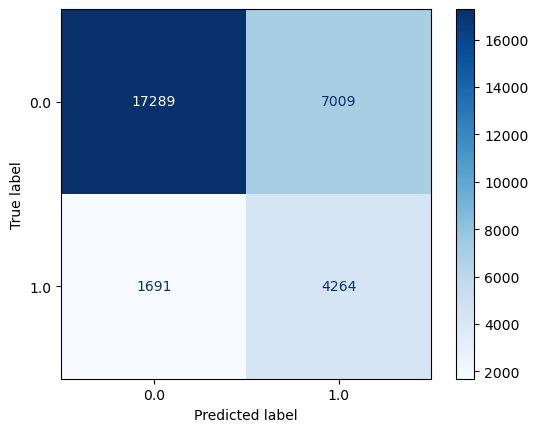

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test, rfc_initial_pred, cmap='Blues')

In [63]:
# Performance metrics
# Compute accuracy score for random forest classifier
rfc_initial_accuracy = accuracy_score(y_test, rfc_initial_pred)
print("Random Forest Classifier Accuracy:", rfc_initial_accuracy)

# Compute f1 score for random forest classifier
rfc_initial_f1 = f1_score(y_test, rfc_initial_pred)
print("Random Forest Classifier F1:", rfc_initial_f1)

# Compute f2 score for random forest classifier
rfc_initial_f2 = fbeta_score(y_test, rfc_initial_pred, beta=2)
print("Random Forest Classifier F2:", rfc_initial_f2)

# Compute precision score for random forest classifier
rfc_initial_precision = precision_score(y_test, rfc_initial_pred)
print("Random Forest Classifier Precision:", rfc_initial_precision)

# Compute recall score for random forest classifier
rfc_initial_recall = recall_score(y_test, rfc_initial_pred)
print("Random Forest Classifier Recall:", rfc_initial_recall)

Random Forest Classifier Accuracy: 0.7124252140283608
Random Forest Classifier F1: 0.4950081263060135
Random Forest Classifier F2: 0.607528566950674
Random Forest Classifier Precision: 0.37824891333274197
Random Forest Classifier Recall: 0.7160369437447524


### XGBoost Classifier <a class="anchor" id="xgbc"></a>

In [64]:
# Train model and make predictions
xgbc_initial = XGBClassifier(eta=0.01, min_child_weight=1, max_depth=6, subsample=0.9, scale_pos_weight=1.1,
                             objective='binary:logistic', eval_metric='rmse', seed=42)
xgbc_initial.fit(X_train_ros, y_train_ros)
xgbc_initial_pred = xgbc_initial.predict(X_test)

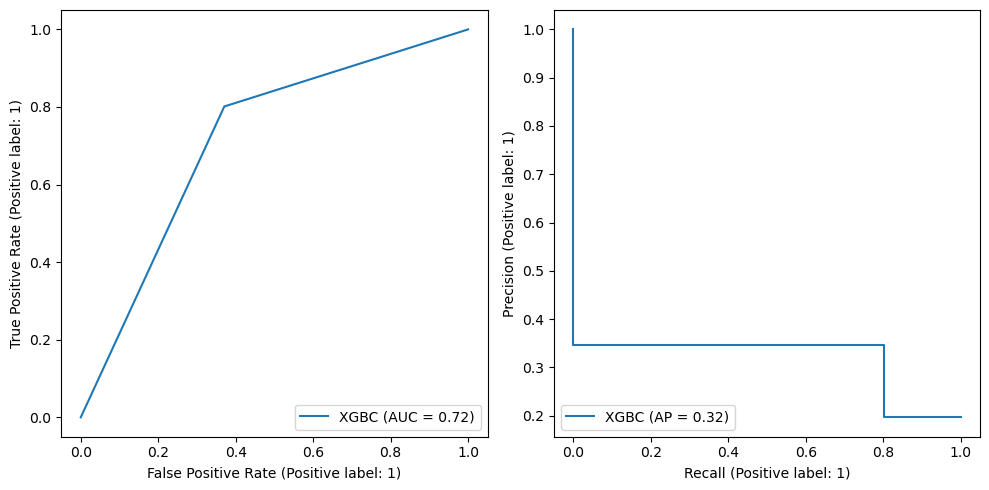

In [97]:
# ROC and Precision/Recall Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
roc_display = RocCurveDisplay.from_predictions(y_test, xgbc_initial_pred, name='XGBC', ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, xgbc_initial_pred, name='XGBC', ax=ax2)
plt.tight_layout()

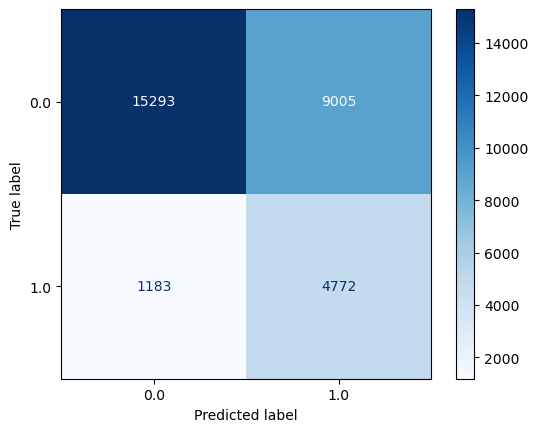

In [66]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgbc_initial_pred, cmap='Blues')

In [67]:
# Performance metrics
# Compute accuracy score for XGB classifier
xgbc_initial_accuracy = accuracy_score(y_test, xgbc_initial_pred)
print("XGBoost Classifier Accuracy:", xgbc_initial_accuracy)

# Compute f1 score for XGB Classifier
xgbc_initial_f1 = f1_score(y_test, xgbc_initial_pred)
print("XGBoost Classifier F1:", xgbc_initial_f1)

# Compute f2 score for XGB Classifier
xgbc_initial_f2 = fbeta_score(y_test, xgbc_initial_pred, beta=2)
print("XGBoost Classifier F2:", xgbc_initial_f2)

# Compute precision score for XGB classifier
xgbc_initial_precision = precision_score(y_test, xgbc_initial_pred)
print("XGBoost Classifier Precision:", xgbc_initial_precision)

# Compute recall score for XGB classifier
xgbc_initial_recall = recall_score(y_test, xgbc_initial_pred)
print("XGBoost Classifier Recall:", xgbc_initial_recall)

XGBoost Classifier Accuracy: 0.6632400092552805
XGBoost Classifier F1: 0.48368132981958245
XGBoost Classifier F2: 0.634625103066734
XGBoost Classifier Precision: 0.34637439210278
XGBoost Classifier Recall: 0.8013434089000839


### Hist Gradient Boosting Classifier <a class="anchor" id="gbc"></a>

In [68]:
# Train model and make predictions
gbc_initial = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100,
                                             max_depth=None, min_samples_leaf=5,
                                             categorical_features=[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                                             early_stopping='auto', scoring='recall', validation_fraction=0.1,
                                             n_iter_no_change=12, random_state=42)
gbc_initial.fit(X_train_ros, y_train_ros)
gbc_initial_pred = gbc_initial.predict(X_test)

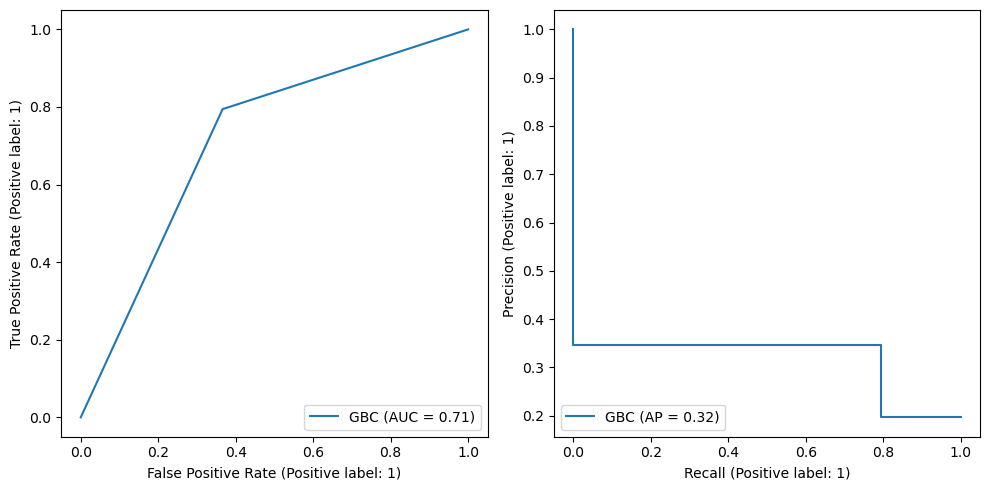

In [96]:
# ROC and Precision/Recall Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
roc_display = RocCurveDisplay.from_predictions(y_test, gbc_initial_pred, name='GBC', ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, gbc_initial_pred, name='GBC', ax=ax2)
plt.tight_layout()

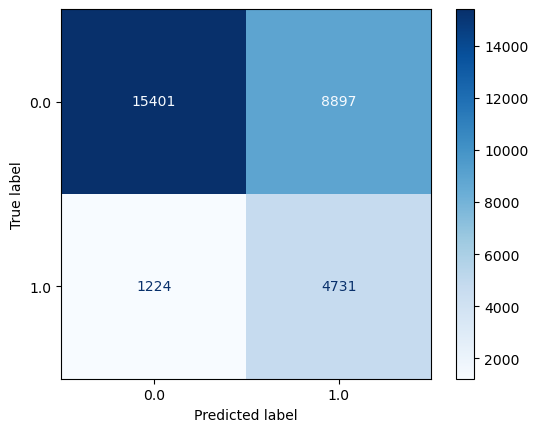

In [70]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, gbc_initial_pred, cmap='Blues')

In [71]:
# Performance metrics
# Compute accuracy score for etc
gbc_initial_accuracy = accuracy_score(y_test, gbc_initial_pred)
print("Gradient Boosted Classifier Accuracy:", gbc_initial_accuracy)

# Compute f1 score for etc
gbc_initial_f1 = f1_score(y_test, gbc_initial_pred)
print("Gradient Boosted Classifier F1:", gbc_initial_f1)

# Compute f2 score for etc
gbc_initial_f2 = fbeta_score(y_test, gbc_initial_pred, beta=2)
print("Gradient Boosted Classifier F2:", gbc_initial_f2)

# Compute precision score for etc
gbc_initial_precision = precision_score(y_test, gbc_initial_pred)
print("Gradient Boosted Classifier Precision:", gbc_initial_precision)

# Compute recall score for etc
gbc_initial_recall = recall_score(y_test, gbc_initial_pred)
print("Gradient Boosted Classifier Recall:", gbc_initial_recall)

Gradient Boosted Classifier Accuracy: 0.665454665652993
Gradient Boosted Classifier F1: 0.4831741816881989
Gradient Boosted Classifier F2: 0.6316759239478744
Gradient Boosted Classifier Precision: 0.3471529204578808
Gradient Boosted Classifier Recall: 0.7944584382871537


### Neural Network <a class="anchor" id="ann"></a>

In [72]:
# Train model
ann_initial = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
ann_initial.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.05), metrics=[tf.keras.metrics.Recall()])
history = ann_initial.fit(X_train_ros, y_train_ros, epochs=25, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/25
12145/12145 [==============================] - 29s 2ms/step - loss: 0.5580 - recall: 0.7568 - val_loss: 0.6045 - val_recall: 0.8157
Epoch 2/25
12145/12145 [==============================] - 29s 2ms/step - loss: 0.5511 - recall: 0.7605 - val_loss: 0.5345 - val_recall: 0.7262
Epoch 3/25
12145/12145 [==============================] - 35s 3ms/step - loss: 0.5492 - recall: 0.7627 - val_loss: 0.5504 - val_recall: 0.7569
Epoch 4/25
12145/12145 [==============================] - 34s 3ms/step - loss: 0.5476 - recall: 0.7628 - val_loss: 0.5774 - val_recall: 0.7855
Epoch 5/25
12145/12145 [==============================] - 31s 3ms/step - loss: 0.5461 - recall: 0.7642 - val_loss: 0.5816 - val_recall: 0.7930
Epoch 6/25
12145/12145 [==============================] - 32s 3ms/step - loss: 0.5446 - recall: 0.7650 - val_loss: 0.5794 - val_recall: 0.7921
Epoch 7/25
12145/12145 [==============================] - 30s 3ms/step - loss: 0.5430 - recall: 0.7648 - val_loss: 0.5918 - val_recall: 0.7913

In [73]:
# Predict probabilities
ann_initial_proba = ann_initial.predict(X_test)
# Use threshold to convert to binary predictions
threshold_initial = 0.5  # Threshold will be changed to reflect importance of recall after hyperparameter tuning
ann_initial_pred = np.where(ann_initial_proba > threshold_initial, 1, 0)

946/946 [==============================] - 2s 1ms/step


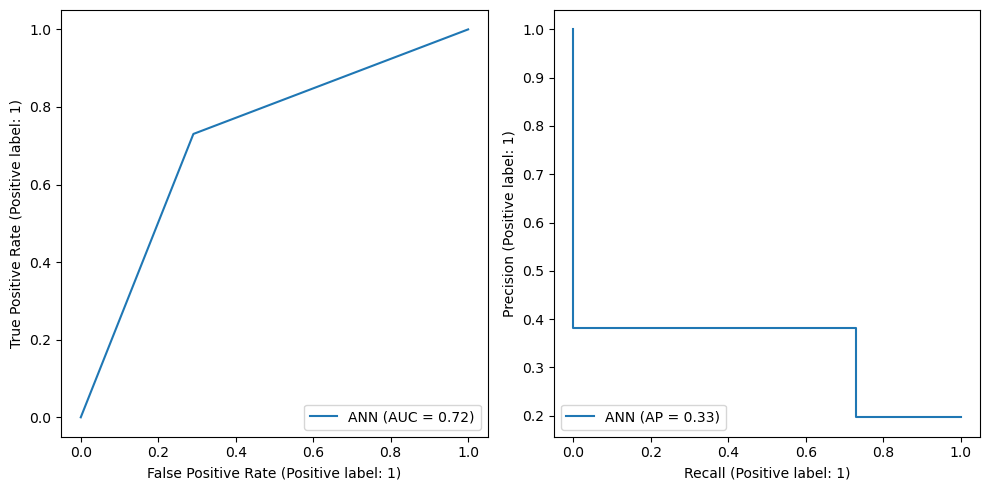

In [74]:
# ROC and Precision/Recall Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
roc_display = RocCurveDisplay.from_predictions(y_test, ann_initial_pred, name='ANN', ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, ann_initial_pred, name='ANN', ax=ax2)
plt.tight_layout()

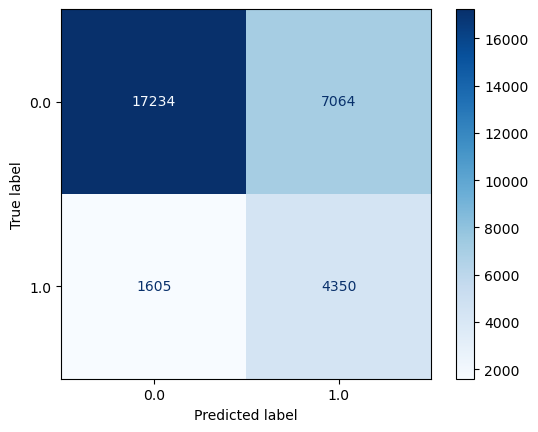

In [75]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, ann_initial_pred, cmap='Blues')

In [76]:
# Performance metrics
# Compute accuracy score for ann
ann_initial_accuracy = accuracy_score(y_test, ann_initial_pred)
print("ANN Accuracy:", ann_initial_accuracy)

# Compute f1 score for ann
ann_initial_f1 = f1_score(y_test, ann_initial_pred)
print("ANN F1:", ann_initial_f1)

# Compute f2 score for ann
ann_initial_f2 = fbeta_score(y_test, ann_initial_pred, beta=2)
print("ANN F2:", ann_initial_f2)

# Compute precision score for ann
ann_initial_precision = precision_score(y_test, ann_initial_pred)
print("ANN Precision:", ann_initial_precision)

# Compute recall score for ann
ann_initial_recall = recall_score(y_test, ann_initial_pred)
print("ANN Recall:", ann_initial_recall)

ANN Accuracy: 0.7134499057944667
ANN F1: 0.500892394495941
ANN F2: 0.6173014701708577
ANN Precision: 0.3811109164184335
ANN Recall: 0.7304785894206549


### Compare all models <a class="anchor" id="all"></a>

In [77]:
# Compare all model scores
initial_scores = {
    'Recall': [lrm_initial_recall, rfc_initial_recall, xgbc_initial_recall, gbc_initial_recall, ann_initial_recall],
    'F2 Score': [lrm_initial_f2, rfc_initial_f2, xgbc_initial_f2, gbc_initial_f2, ann_initial_f2],
    'Precision': [lrm_initial_precision, rfc_initial_precision, xgbc_initial_precision, gbc_initial_precision, ann_initial_precision],
    'F1 Score': [lrm_initial_f1, rfc_initial_f1, xgbc_initial_f1, gbc_initial_f1, ann_initial_f1],
    'Accuracy': [lrm_initial_accuracy, rfc_initial_accuracy, xgbc_initial_accuracy, gbc_initial_accuracy, ann_initial_accuracy],
}

initial_model_metrics = pd.DataFrame(initial_scores, index=['LRM', 'Random Forest Classifier', 'XGBoost Classifier', 'HGBC', 'ANN'])
initial_model_metrics

,Recall,F2 Score,Precision,F1 Score,Accuracy
LRM,0.771453,0.628489,0.360937,0.491784,0.686147
Random Forest Classifier,0.716037,0.607529,0.378249,0.495008,0.712425
XGBoost Classifier,0.801343,0.634625,0.346374,0.483681,0.663240
HGBC,0.794458,0.631676,0.347153,0.483174,0.665455
ANN,0.730479,0.617301,0.381111,0.500892,0.713450


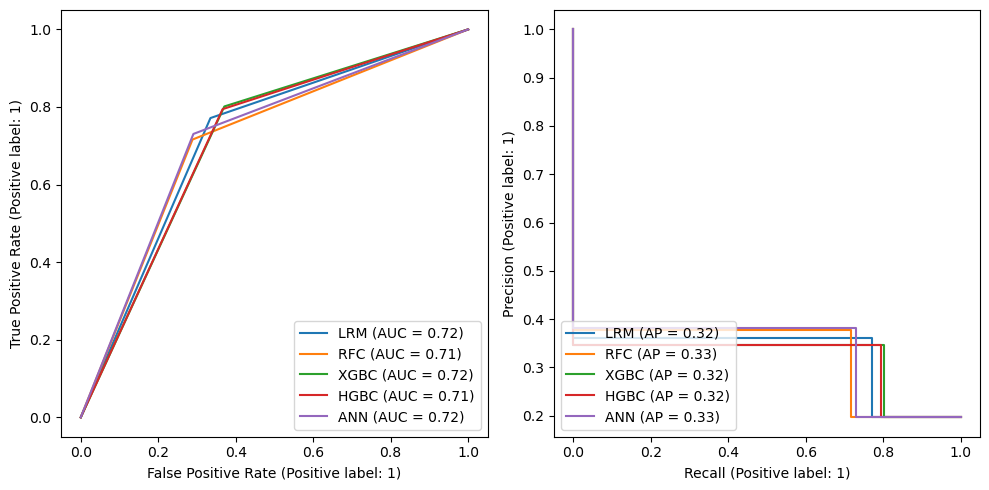

In [78]:
# Plot all initial models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
RocCurveDisplay.from_predictions(y_test, lrm_initial_pred, ax=ax1, name='LRM')
RocCurveDisplay.from_predictions(y_test, rfc_initial_pred, ax=ax1, name='RFC')
RocCurveDisplay.from_predictions(y_test, xgbc_initial_pred, ax=ax1, name='XGBC')
RocCurveDisplay.from_predictions(y_test, gbc_initial_pred, ax=ax1, name='HGBC')
RocCurveDisplay.from_predictions(y_test, ann_initial_pred, ax=ax1, name='ANN')
PrecisionRecallDisplay.from_predictions(y_test, lrm_initial_pred, ax=ax2, name='LRM')
PrecisionRecallDisplay.from_predictions(y_test, rfc_initial_pred, ax=ax2, name='RFC')
PrecisionRecallDisplay.from_predictions(y_test, xgbc_initial_pred, ax=ax2, name='XGBC')
PrecisionRecallDisplay.from_predictions(y_test, gbc_initial_pred, ax=ax2, name='HGBC')
PrecisionRecallDisplay.from_predictions(y_test, ann_initial_pred, ax=ax2, name='ANN')
plt.tight_layout()

## Optimal Model Selection and Hyperparameter Tuning <a class="anchor" id="optimal"></a>
The models trained with their initial hyperparameters all had very similar performance. Upon evaluating all metrics of the models above, the two best performing models were the XGBoost Classifier and the Hist Gradient Boosting Classifier, with the XGBoost Classifier performing slightly better.

In this section we will perform grid searches to find the optimal model hyperparameters, and return the best model hyperparameters to use in training our final models. The evaluation metric which we will be using for the grid search will be recall. This is because our most important metrics for model evaluation are recall and f2 score due to how they align with the goals of this project, with recall taking a greater importance.

### XGBC Grid Search <a class="anchor" id="pptimal1"></a>

In [79]:
#XGBC GridSearch
xgbc_param_grid1 = {'eta': [0.009, 0.01, 0.11],
                    'min_child_weight': [1, 3],
                   'max_depth' : [6, 7, 8],
                   'subsample': [0.9, 1]}

gs_xgbc = GridSearchCV(XGBClassifier(scale_pos_weight=1.1,objective='binary:logistic',
                                     eval_metric='rmse', seed=42), xgbc_param_grid1, scoring='recall', verbose=3, cv=3)
gs_xgbc.fit(X_train_ros, y_train_ros)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END eta=0.009, max_depth=6, min_child_weight=1, subsample=0.9;, score=0.796 total time=   8.3s
[CV 2/3] END eta=0.009, max_depth=6, min_child_weight=1, subsample=0.9;, score=0.797 total time=   8.7s
[CV 3/3] END eta=0.009, max_depth=6, min_child_weight=1, subsample=0.9;, score=0.799 total time=   8.9s
[CV 1/3] END eta=0.009, max_depth=6, min_child_weight=1, subsample=1;, score=0.797 total time=   7.7s
[CV 2/3] END eta=0.009, max_depth=6, min_child_weight=1, subsample=1;, score=0.798 total time=   7.9s
[CV 3/3] END eta=0.009, max_depth=6, min_child_weight=1, subsample=1;, score=0.798 total time=   8.5s
[CV 1/3] END eta=0.009, max_depth=6, min_child_weight=3, subsample=0.9;, score=0.796 total time=   9.5s
[CV 2/3] END eta=0.009, max_depth=6, min_child_weight=3, subsample=0.9;, score=0.797 total time=   8.7s
[CV 3/3] END eta=0.009, max_depth=6, min_child_weight=3, subsample=0.9;, score=0.799 total time=   9.0s
[CV 1/3]

[CV 3/3] END eta=0.11, max_depth=6, min_child_weight=3, subsample=0.9;, score=0.792 total time=   9.0s
[CV 1/3] END eta=0.11, max_depth=6, min_child_weight=3, subsample=1;, score=0.794 total time=   7.7s
[CV 2/3] END eta=0.11, max_depth=6, min_child_weight=3, subsample=1;, score=0.797 total time=   7.6s
[CV 3/3] END eta=0.11, max_depth=6, min_child_weight=3, subsample=1;, score=0.794 total time=   7.2s
[CV 1/3] END eta=0.11, max_depth=7, min_child_weight=1, subsample=0.9;, score=0.800 total time=  10.1s
[CV 2/3] END eta=0.11, max_depth=7, min_child_weight=1, subsample=0.9;, score=0.803 total time=   9.7s
[CV 3/3] END eta=0.11, max_depth=7, min_child_weight=1, subsample=0.9;, score=0.800 total time=  10.6s
[CV 1/3] END eta=0.11, max_depth=7, min_child_weight=1, subsample=1;, score=0.799 total time=   8.3s
[CV 2/3] END eta=0.11, max_depth=7, min_child_weight=1, subsample=1;, score=0.802 total time=   8.2s
[CV 3/3] END eta=0.11, max_depth=7, min_child_weight=1, subsample=1;, score=0.799 t

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='rmse', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.009, 0.01, 0.11], 'max_depth': [6, 7, 8],
                         'min_child_weight': [1, 3], 'subsample': [0.9, 1]},
             scoring='recall', verbose=3)

In [80]:
gs_xgbc.best_params_

{'eta': 0.11, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9}

### HGBC Grid Search <a class="anchor" id="optimal2"></a>

In [85]:
#HGBC GridSearch
hgbc_param_grid1 = {'learning_rate': [0.009, 0.01, 0.11],
                    'max_iter': [90, 100, 110],
                    'max_depth': [32, 30],
                   'min_samples_leaf' : [5, 6, 7]}

gs_hgbc = GridSearchCV(HistGradientBoostingClassifier(
    categorical_features=[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], early_stopping='auto',
    scoring='recall', validation_fraction=0.1, n_iter_no_change=12, random_state=42), hgbc_param_grid1, scoring='recall',
                       verbose=3, cv=3)
gs_hgbc.fit(X_train_ros, y_train_ros)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=5;, score=0.749 total time=   2.7s
[CV 2/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=5;, score=0.739 total time=   1.7s
[CV 3/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=5;, score=0.733 total time=   2.6s
[CV 1/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=6;, score=0.749 total time=   2.9s
[CV 2/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=6;, score=0.739 total time=   1.7s
[CV 3/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=6;, score=0.733 total time=   2.9s
[CV 1/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=7;, score=0.749 total time=   2.8s
[CV 2/3] END learning_rate=0.009, max_depth=32, max_iter=90, min_samples_leaf=7;, score=0.739 total time=   1.8s
[CV 3/3] END learning_rate=0.009, 

[CV 1/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=5;, score=0.746 total time=   3.3s
[CV 2/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=5;, score=0.744 total time=   2.0s
[CV 3/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=5;, score=0.735 total time=   2.6s
[CV 1/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=6;, score=0.746 total time=   3.1s
[CV 2/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=6;, score=0.744 total time=   2.2s
[CV 3/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=6;, score=0.735 total time=   2.5s
[CV 1/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=7;, score=0.746 total time=   3.2s
[CV 2/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=7;, score=0.744 total time=   2.0s
[CV 3/3] END learning_rate=0.01, max_depth=32, max_iter=110, min_samples_leaf=7;, score=0.735 to

[CV 2/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=5;, score=0.762 total time=   1.4s
[CV 3/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=5;, score=0.591 total time=   5.1s
[CV 1/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=6;, score=0.604 total time=   4.5s
[CV 2/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=6;, score=0.762 total time=   1.4s
[CV 3/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=6;, score=0.576 total time=   5.9s
[CV 1/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=7;, score=0.563 total time=   5.2s
[CV 2/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=7;, score=0.762 total time=   1.6s
[CV 3/3] END learning_rate=0.11, max_depth=30, max_iter=100, min_samples_leaf=7;, score=0.622 total time=   5.4s
[CV 1/3] END learning_rate=0.11, max_depth=30, max_iter=110, min_samples_leaf=5;, score=0.521 to

GridSearchCV(cv=3,
             estimator=HistGradientBoostingClassifier(categorical_features=[0,
                                                                            0,
                                                                            0,
                                                                            0,
                                                                            0,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1,
                                                                            1, ...],
                                                      n_iter_no_change=12,
                                                      random_state=42,
                                                      scoring='recall'),
             param_grid={'learning_rate': [0.009, 0.01, 0.11],
                         'max_depth': [32, 30], 'max_iter': [90, 100, 110],
                         'min_samples_leaf': [5, 6, 7]},
             scoring='recall', verbose=3)

In [86]:
gs_hgbc.best_params_

{'learning_rate': 0.01, 'max_depth': 32, 'max_iter': 90, 'min_samples_leaf': 5}

## Final Model Selection <a class="anchor" id="final"></a>
In this section we will use the best parameters returned from the grid searches of our final two models and compare the performance of the tuned models. Once we have determined the appropriate model to use, we will perform threshold tuning on this model to better fit our importance of acheiving a high recall.

In [87]:
# Tuned XGBC
xgbc_final = XGBClassifier(**gs_xgbc.best_params_, scale_pos_weight=1.1,objective='binary:logistic', eval_metric='rmse',
                           seed=42)
xgbc_final.fit(X_train_ros, y_train_ros)
xgbc_final_pred = xgbc_final.predict(X_test)

In [88]:
# Tuned XGBC
hgbc_final = HistGradientBoostingClassifier(**gs_hgbc.best_params_,
                                            categorical_features=[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                                            early_stopping='auto', scoring='recall', validation_fraction=0.1,
                                            n_iter_no_change=12, random_state=42)
hgbc_final.fit(X_train_ros, y_train_ros)
hgbc_final_pred = hgbc_final.predict(X_test)

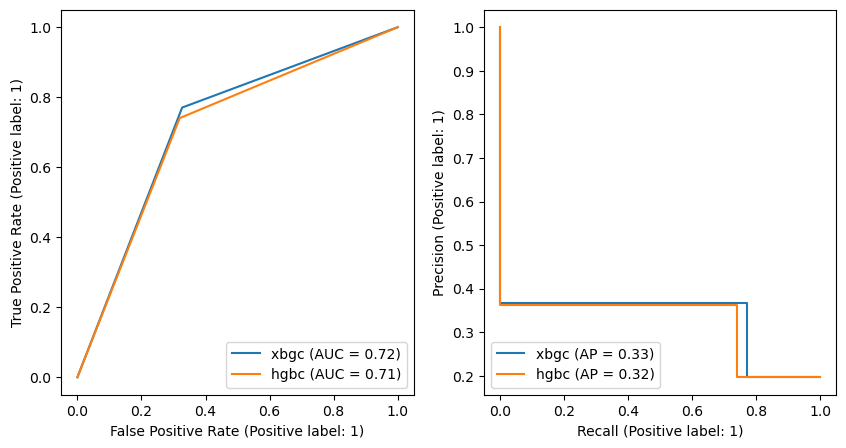

In [89]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
RocCurveDisplay.from_predictions(y_test, xgbc_final_pred, ax=ax1, name='xbgc')
RocCurveDisplay.from_predictions(y_test, hgbc_final_pred, ax=ax1, name='hgbc')
PrecisionRecallDisplay.from_predictions(y_test, xgbc_final_pred, ax=ax2, name='xbgc')
PrecisionRecallDisplay.from_predictions(y_test, hgbc_final_pred, ax=ax2, name='hgbc')
plt.show()

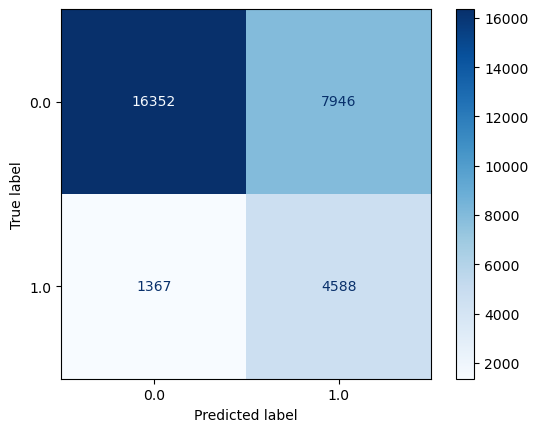

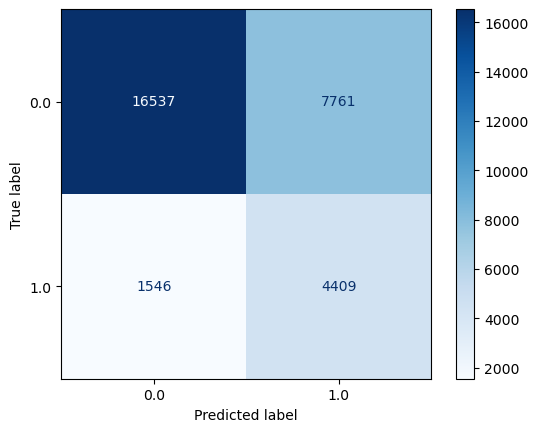

In [90]:
#Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgbc_final_pred, cmap='Blues')
ConfusionMatrixDisplay.from_predictions(y_test, hgbc_final_pred, cmap='Blues')

In [91]:
# Metrics
# Compute accuracy score for XGB classifier
xgbc_final_accuracy = accuracy_score(y_test, xgbc_final_pred)
# Compute f1 score for XGB Classifier
xgbc_final_f1 = f1_score(y_test, xgbc_final_pred)
# Compute f2 score for XGB Classifier
xgbc_final_f2 = fbeta_score(y_test, xgbc_final_pred, beta=2)
# Compute precision score for XGB classifier
xgbc_final_precision = precision_score(y_test, xgbc_final_pred)
# Compute recall score for XGB classifier
xgbc_final_recall = recall_score(y_test, xgbc_final_pred)
# Compute accuracy score for HGB classifier
hgbc_final_accuracy = accuracy_score(y_test, hgbc_final_pred)
# Compute f1 score for HGB classifier
hgbc_final_f1 = f1_score(y_test, hgbc_final_pred)
# Compute f2 score for HGB classifier
hgbc_final_f2 = fbeta_score(y_test, hgbc_final_pred, beta=2)
# Compute precision score for HGB classifier
hgbc_final_precision = precision_score(y_test, hgbc_final_pred)
# Compute recall score for HGB classifier
hgbc_final_recall = recall_score(y_test, hgbc_final_pred)
# Compare all model scores
final_scores = {
    'Recall': [xgbc_final_recall, hgbc_final_recall],
    'F2 Score': [xgbc_final_f2, hgbc_final_f2],
    'Precision': [xgbc_final_precision, hgbc_final_precision],
    'F1 Score': [xgbc_final_f1, hgbc_final_f1],
    'Accuracy': [xgbc_final_accuracy, hgbc_final_accuracy],
}

final_model_metrics = pd.DataFrame(final_scores, index=['XGBoost Classifier', 'Hist Gradient Boosting Classifier'])
final_model_metrics

,Recall,F2 Score,Precision,F1 Score,Accuracy
XGBoost Classifier,0.770445,0.631017,0.366044,0.496295,0.692163
Hist Gradient Boosting Classifier,0.740386,0.612531,0.362284,0.486510,0.692361


The model with the best final performance is the XGBoost Classifier. Next, we will perform threshold tuning on the XGBoost Classifier, by using the trained model to generate probabilities, which we can then compare across a range of thresholds and f2 scores, to determine the threshold which optimizes our f2 score. F2 score was chosen because it places a greater importance on recall, and due to the trade off between precision and recall, we do not want to completely abandon the little precision we have in favor of greater recall.

In [107]:
# Threshold tuning by f2 score
from numpy import argmax

def labels(proba, threshold):
 return (proba >= threshold).astype('int')

xgbc_final_proba = xgbc_final.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.0, step=0.01)
f2_scores = [fbeta_score(y_test, labels(xgbc_final_proba, t), beta=2) for t in thresholds]
target = argmax(f2_scores)
print('Threshold=', thresholds[target])
print('Associated F2 Score=', f2_scores[target])

Threshold= 0.38
Associated F2 Score= 0.6467927529388373


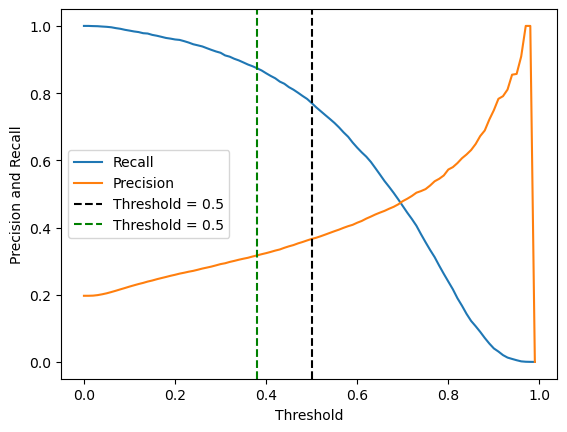

In [106]:
#Plot Precision vs Recall and mark threshold change
recall_scores = [recall_score(y_test, xgbc_final_proba > t) for t in thresholds]
precis_scores = [precision_score(y_test, xgbc_final_proba > t) for t in thresholds]
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall")
ax.plot(thresholds, precis_scores, label="Precision")
ax.axvline(0.5, c="black", linestyle="--", label="Threshold = 0.5")
ax.axvline(0.38, c="green", linestyle="--", label="Threshold = 0.38")
ax.set_xlabel("Threshold")
ax.set_ylabel("Precision and Recall")
ax.legend()
plt.show()

In [111]:
# Use threshold to make predicitons
final_threshold = 0.38  # New threshold
xgbc_pred = np.where(xgbc_final_proba > final_threshold, 1, 0)

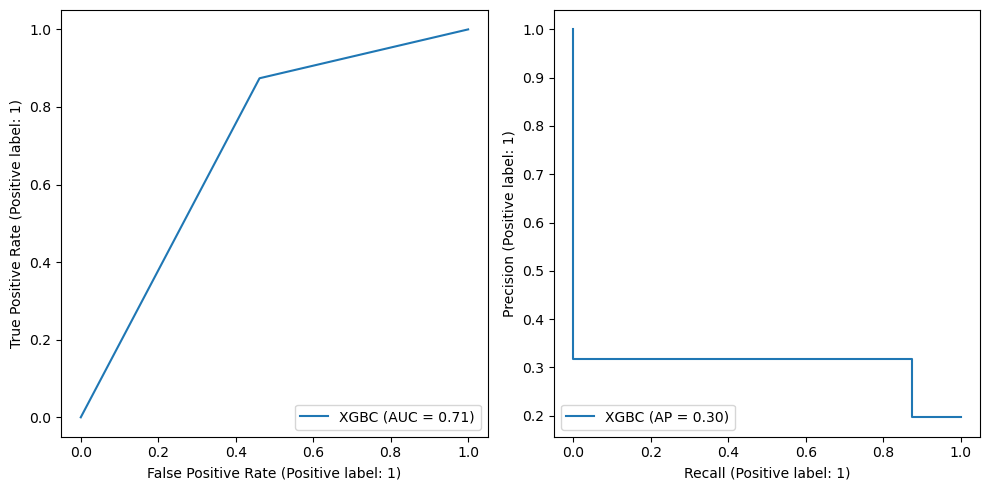

In [112]:
# Final ROC and Precision/Recall Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
roc_display = RocCurveDisplay.from_predictions(y_test, xgbc_pred, name='XGBC', ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, xgbc_pred, name='XGBC', ax=ax2)
plt.tight_layout()

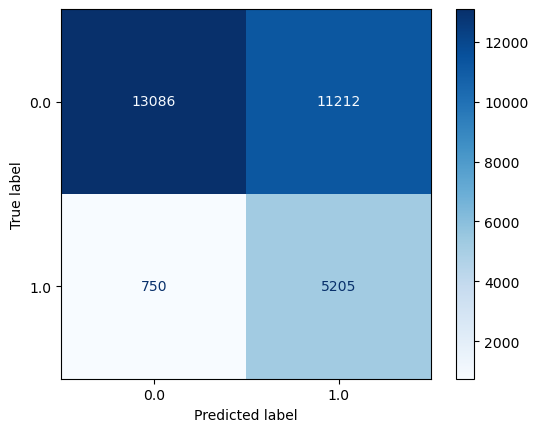

In [113]:
# Final Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgbc_pred, cmap='Blues')

In [114]:
# Final Performance metrics
# Compute accuracy score for XGB classifier
xgbc_accuracy = accuracy_score(y_test, xgbc_pred)
print("XGBoost Classifier Accuracy:", xgbc_accuracy)

# Compute f1 score for XGB Classifier
xgbc_f1 = f1_score(y_test, xgbc_pred)
print("XGBoost Classifier F1:", xgbc_f1)

# Compute f2 score for XGB Classifier
xgbc_f2 = fbeta_score(y_test, xgbc_pred, beta=2)
print("XGBoost Classifier F2:", xgbc_f2)

# Compute precision score for XGB classifier
xgbc_precision = precision_score(y_test, xgbc_pred)
print("XGBoost Classifier Precision:", xgbc_precision)

# Compute recall score for XGB classifier
xgbc_recall = recall_score(y_test, xgbc_pred)
print("XGBoost Classifier Recall:", xgbc_recall)

XGBoost Classifier Accuracy: 0.6046011965755462
XGBoost Classifier F1: 0.4653137850885035
XGBoost Classifier F2: 0.6467927529388373
XGBoost Classifier Precision: 0.3170494000121825
XGBoost Classifier Recall: 0.8740554156171285


## Discussion <a class="anchor" id="deploy"></a>

The performance metrics suggest that there were significant problems involved with training the model. Despite the final model having a recall score of 0.87 (which was identified as being particularly important in our specific use case), it still fell short in other areas such as precision (0.31) and accuracy (0.60). There are a number of reasons that the models could have ended up with poor performance. The first, is the initial quality of the data. If I were to do this or a similar project over again, I would attempt to examine different sources of data. A couple of examples of this would be data that spans across years, involves a greater number of relevant behaviors, and wherever possible has values which are measured as opposed to self-reported. Self-reported data brings the reliability of the reports into question, and could potentially be a source of error regarding behaviors that people are unwilling to report, or embellish.

Another potential reason for poor performance of the models is due to my data processing. Examining different feature transformations, feature selection methods, statistical transformations, and pre-processing techniques could potentially have yielded better models. I was at times overwhelmed with the different possible solutions to every aspect of the problem at hand, and with more experience and education, could potentially source much more effective solutions.

This lack of experience was also evident in model selection, training, and evaluation. Given the opportunity to complete the process again, I would like to examine the use of a wider range of models, as well as a wider range of hyperparameter tuning methods. One such example is the use of different hyperparameters for tuning neural networks. I found a number of different tools that could be used, however, due to my lack of experience and the time constraints for the project, I opted to use a grid search instead.

Despite the lower performance of the models, due to the emphasis of recall on diabetes classification, the model could still prove useful. The trained models will be used in a Flask web application, where an individual can input answers to questions in a modified and shortened version of the questionnaire which was used to produce the original data. From this, with only a few entries, a prediction can be made as to whether or not the individual is likely to have diabetes or prediabetes, and has the added benefit of spurring research or discussion among users about diabetes risk factors. If it can be used to encourage people with risky health behaviors to seek advice or examine their behaviors, it is a success in at least one dimension.

The model results in general point towards the difficulty of classifying a disease state such as diabetes, when the measures used are not as precise as many taken by healthcare professionals for diagnosis due to them being environmental and behavioral variables. This highlights the opportunity to use models such as these, to identify behaviors and environmental conditions which could be classified as risk factors for disease.


In [115]:
# Save MinMaxScaler
joblib.dump(scaler, "scaler.joblib")
# Save model
joblib.dump(xgbc_final, "model.joblib")

['model.joblib']

## References <a class="anchor" id="twelvth-bullet"></a>

1. World Health Organization. Diabetes. WHO Website. Published 2022. Accessed May 20,
2023. https://www.who.int/health-topics/diabetes#tab=tab_1
2. World Health Organization. Diabetes Facts Sheet. WHO Website. Published October 30,
2018. Accessed May 20, 2023. https://www.who.int/en/news-room/fact-sheets/detail/diabetes
3. National Institute of Diabetes and Digestive and Kidney Diseases. Symptoms & Causes
of Diabetes | NIDDK. NIDDK Website. Published December 2016. Accessed May 20, 2023.
https://www.niddk.nih.gov/health-information/diabetes/overview/symptoms-causes?dkrd=hiscr00
05
4. National Institute of Diabetes and Digestive and Kidney Diseases. Risk factors for type 2
diabetes. NIDDK Website. Published March 6, 2019. Accessed May 20, 2023.
https://www.niddk.nih.gov/health-information/diabetes/overview/risk-factors-type-2-diabetes
5. National Institute of Diabetes and Digestive and Kidney Diseases. Risk Factors for
Diabetes | NIDDK. NIDDK Website. Accessed May 20, 2023.
https://www.niddk.nih.gov/health-information/professionals/clinical-tools-patient-management/di
abetes/game-plan-preventing-type-2-diabetes/prediabetes-screening-how-why/risk-factors-diab
etes#:~:text=Risk%20Factors%20for%20Diabetes%201%20Age%20%E2%89%A5%2045
6. National Institute of Diabetes and Digestive and Kidney Diseases. What is Diabetes?
NIDDK Website. Published December 2016. Accessed May 20, 2023.
https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes
7. Centers for Disease Control and Prevention. By the Numbers: Diabetes in America. CDC
Website. Published March 28, 2022. Accessed May 20, 2023.
https://www.cdc.gov/diabetes/health-equity/diabetes-by-the-numbers.html
8. National Institute of Diabetes and Digestive and Kidney Diseases. Insulin Resistance &
Prediabetes | NIDDK. NIDDK Website. Published March 3, 2019. Accessed May 20, 2023.
https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes/prediabetes-ins
ulin-resistance
9. Centers for Disease Control and Prevention. CDC - BRFSS. CDC Website. Published
2019. Accessed May 18, 2023. https://www.cdc.gov/brfss/index.html
10. Centers for Disease Control and Prevention. CDC - BRFSS Annual Survey Data. CDC
Website. Published July 26, 2022. Accessed May 18, 2023.
https://www.google.com/url?q=https://www.cdc.gov/brfss/annual_data/annual_data.htm&sa=D&
source=docs&ust=1685129061390099&usg=AOvVaw0ShWwoZXUMNWiRaMnODno6
11. Emre A. BRFSS 2020 Survey Data. Kaggle. Accessed May 25, 2023.
https://www.kaggle.com/datasets/aemreusta/brfss-2020-survey-data
12. Centers for Disease Control and Prevention. CDC - 2020 BRFSS Survey Data and
Documentation. CDC Website. Published August 27, 2021. Accessed May 18, 2023.
https://www.cdc.gov/brfss/annual_data/annual_2020.html